# STATIC

In [ ]:
# @title
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import VarianceThreshold
from lightgbm import LGBMRegressor, log_evaluation

# ==========================
# CONFIG

# ==========================
DATASET_PATH = '/content/ml_code_dataset.csv'  # <- update to your file
TARGET = 'energy_consumption_joules'

# Lists (static/dynamic/metadata)
DYNAMIC_FEATURES = [
    'execution_time', 'runtime_seconds', 'elapsed_time', 'duration',
    'memory_peak_mb', 'memory_avg_mb', 'memory_usage', 'memory_allocated',
    'memory_reserved', 'memory_max', 'ram_usage', 'heap_size',
    'cpu_percent_avg', 'cpu_percent_peak', 'cpu_usage', 'cpu_time',
    'user_time', 'system_time', 'cpu_cycles',
    'disk_read_mb', 'disk_write_mb', 'io_read', 'io_write',
    'disk_operations', 'read_bytes', 'write_bytes',
    'co2_emissions_g', 'power_draw_watts', 'energy_pkg_joules',
    'energy_ram_joules', 'energy_consumption', 'carbon_footprint',
    'gpu_used', 'gpu_memory', 'gpu_utilization', 'cuda_memory',
    'network_sent_mb', 'network_recv_mb', 'bytes_sent', 'bytes_received',
    'packets_sent', 'packets_received',
    'process_count', 'thread_count', 'context_switches', 'num_threads',
    'num_processes', 'child_processes',
    'cache_misses', 'cache_hits', 'instructions_retired', 'cycles_elapsed',
    'branch_misses', 'page_faults', 'tlb_misses',
    'runtime_errors', 'memory_errors', 'exception_count', 'error_count',
    'warning_count', 'num_exceptions',
    'output_size', 'return_value', 'stdout_length', 'stderr_length',
    'output_lines', 'print_statements_executed',
    'system_load', 'available_memory', 'free_disk', 'temperature',
]

METADATA_COLS = [
    'file_path', 'file_name', 'repo_name', 'repo_url', 'timestamp',
    'executed_successfully', 'syntax_valid', 'run_id', 'index', 'id',
    'file_id', 'repository', 'author', 'date_created', 'date_modified'
]

dynamic_keywords = [
    'time', 'memory', 'cpu', 'disk', 'io', 'network', 'gpu',
    'peak', 'avg', 'max', 'min', 'usage', 'consumed', 'allocated',
    'runtime', 'execution', 'process', 'thread', 'energy', 'power',
    'emission', 'carbon', 'watt', 'joule', 'exception', 'error',
    'output', 'result', 'performance', 'utilization', 'load'
]

# Helper for safe column printing
def safe_print_cols(cols, title=None, max_show=40):
    if title:
        print(title)
    for c in (cols[:max_show]):
        print(f"   - {c}")
    if len(cols) > max_show:
        print(f"   ... and {len(cols)-max_show} more")

# ==========================
# LOAD & BASIC FILTERING
# ==========================
print("=" * 80)
print("PURE STATIC FEATURES MODEL - DEBUGGED")
print("=" * 80)

df = pd.read_csv(DATASET_PATH)
print(f"\n📊 Initial dataset: {len(df):,} rows × {df.shape[1]} columns")

# Filter for executed_successfully if available
if 'executed_successfully' in df.columns:
    before = len(df)
    df = df[df['executed_successfully'] == True].copy()
    after = len(df)
    print(f"✅ After filtering executed_successfully: {after:,} rows ({after/before*100:.1f}% of pre-filter)")

# Ensure target exists and remove zero/NaN
if TARGET not in df.columns:
    raise SystemExit(f"ERROR: Target '{TARGET}' not found. Columns: {df.columns.tolist()}")

df = df.dropna(subset=[TARGET])
df = df[df[TARGET] > 0].copy()
print(f"✅ After removing zero/NaN target: {len(df):,} rows")

if len(df) < 10:
    raise SystemExit("ERROR: Too few rows remain after initial filtering to train a model safely.")

# ==========================
# IDENTIFY PURE STATIC FEATURES
# ==========================
print("\n🔍 Identifying PURE STATIC features...")

all_cols = df.columns.tolist()
candidates = [c for c in all_cols if c not in (DYNAMIC_FEATURES + METADATA_COLS + [TARGET])]

static_features = []
removed_suspicious = []
for col in candidates:
    low = col.lower()
    if any(k in low for k in dynamic_keywords):
        removed_suspicious.append(col)
    else:
        static_features.append(col)

print(f"\n📋 Feature filtering summary:")
print(f"   Total columns: {len(all_cols)}")
print(f"   Removed metadata columns: {len([c for c in all_cols if c in METADATA_COLS])}")
print(f"   Removed explicit dynamic features: {len([c for c in all_cols if c in DYNAMIC_FEATURES])}")
print(f"   Removed suspicious keyword matches: {len(removed_suspicious)}")
print(f"   ✅ Candidate static features (pre-numeric): {len(static_features)}")

if removed_suspicious:
    safe_print_cols(removed_suspicious, title="⚠️ Example removed suspicious columns:", max_show=20)

if len(static_features) == 0:
    print("\n❌ No static features detected. Listing all columns for debugging:")
    safe_print_cols(all_cols, title="All columns:")
    raise SystemExit("No static features found. Adjust lists or dataset.")

# ==========================
# KEEP ONLY NUMERIC STATIC FEATURES
# ==========================
X_raw = df[static_features].copy()
y = df[TARGET].copy()

# Coerce non-numeric to numeric where possible (non-convertible => NaN)
for col in X_raw.columns:
    if not pd.api.types.is_numeric_dtype(X_raw[col]):
        X_raw[col] = pd.to_numeric(X_raw[col], errors='coerce')

# Drop columns that became all-NaN
num_cols = [c for c in X_raw.columns if X_raw[c].notna().any()]
X = X_raw[num_cols].copy()
dropped_non_numeric = set(static_features) - set(num_cols)
if dropped_non_numeric:
    print(f"\nℹ️ Dropped non-numeric/all-NaN static features: {len(dropped_non_numeric)}")
    safe_print_cols(sorted(list(dropped_non_numeric)), title=" Examples dropped:", max_show=20)

print(f"\n📐 Feature matrix: {X.shape[0]:,} rows × {X.shape[1]} features")

if X.shape[1] == 0:
    raise SystemExit("ERROR: No numeric static features available after coercion.")

# ==========================
# CLEAN INF / MISSING
# ==========================
print("\n🧹 Cleaning feature matrix (infs -> NaN, drop high-missing, fill medians)...")
X.replace([np.inf, -np.inf], np.nan, inplace=True)

missing_pct = X.isna().sum() / len(X)
cols_to_drop = missing_pct[missing_pct > 0.5].index.tolist()
if cols_to_drop:
    X.drop(columns=cols_to_drop, inplace=True)
    print(f"   Dropped {len(cols_to_drop)} columns with >50% missing")

# Fill remaining NaNs with median
for col in X.columns:
    if X[col].isna().sum() > 0:
        X[col].fillna(X[col].median(), inplace=True)

print(f"✅ After cleaning: {X.shape[1]} features remain")

# ==========================
# REMOVE CONSTANT / LOW VARIANCE
# ==========================
print("\n🔧 Removing constant and very low-variance features...")
constant_cols = [col for col in X.columns if X[col].nunique() <= 1]
if constant_cols:
    X.drop(columns=constant_cols, inplace=True)
    print(f"   Removed {len(constant_cols)} constant features")

if X.shape[1] > 0:
    vt = VarianceThreshold(threshold=0.0)
    vt.fit(X)
    variances = vt.variances_
    variance_cutoff = np.percentile(variances, 5)
    keep_mask = variances > variance_cutoff
    cols_kept = X.columns[keep_mask]
    X = X[cols_kept]
    print(f"   After low-variance filtering: {X.shape[1]} features remain")

if X.shape[1] == 0:
    raise SystemExit("ERROR: No features remain after variance filtering.")

print(f"✅ Final static feature count: {X.shape[1]}")

# ==========================
# AGGRESSIVE OUTLIER REMOVAL
# ==========================
print("\n🔍 Aggressive outlier removal (IsolationForest -> quantiles -> z-score)...")
X_clean = X.copy()
y_clean = y.loc[X_clean.index].copy()

print(f"   Initial samples: {X_clean.shape[0]:,}")

# IsolationForest (skip if too few samples)
if X_clean.shape[0] > 20:
    try:
        iso = IsolationForest(contamination=0.10, random_state=42, n_estimators=200, max_samples='auto')
        pred = iso.fit_predict(X_clean)
        mask_iso = pred == 1
        X_clean = X_clean.loc[mask_iso].copy()
        y_clean = y_clean.loc[mask_iso].copy()
        print(f"   After IsolationForest (10% removal): {X_clean.shape[0]:,} samples")
    except Exception as e:
        print(f"   ⚠️ IsolationForest failed: {e}. Skipping this step.")
else:
    print("   ⚠️ Too few samples for IsolationForest - skipping.")

# Quantile filter on target
q_low = y_clean.quantile(0.01)
q_high = y_clean.quantile(0.97)
mask_q = (y_clean >= q_low) & (y_clean <= q_high)
X_clean = X_clean.loc[mask_q].copy()
y_clean = y_clean.loc[mask_q].copy()
print(f"   After quantile filtering (1%-97%): {X_clean.shape[0]:,} samples")

# Z-score filter per feature
stds = X_clean.std()
zero_std_cols = stds[stds == 0].index.tolist()
if zero_std_cols:
    X_clean.drop(columns=zero_std_cols, inplace=True)
    print(f"   Dropped {len(zero_std_cols)} zero-std columns before z-score filtering")

if X_clean.shape[0] > 0 and X_clean.shape[1] > 0:
    z_scores = np.abs((X_clean - X_clean.mean()) / X_clean.std(ddof=0))
    mask_z = (z_scores < 3.5).all(axis=1)
    X_clean = X_clean.loc[mask_z].copy()
    y_clean = y_clean.loc[mask_z].copy()
    print(f"   After z-score filtering (3.5σ): {X_clean.shape[0]:,} samples")
else:
    print("   ⚠️ No samples/features left to perform z-score filtering.")

removed_count = X.shape[0] - X_clean.shape[0]
print(f"✅ Total outliers removed (feature-rows): {removed_count:,} ({(removed_count / max(1, X.shape[0]))*100:.1f}%)")

if X_clean.shape[0] < 20:
    print("⚠️ Warning: Very few samples remain after outlier removal. Model may be unstable.")

# ==========================
# TARGET TRANSFORM
# ==========================
y_log = np.log1p(y_clean)
print("\n📈 Applied log1p to target:")
print(f"   Original target range: [{y_clean.min():.2f}, {y_clean.max():.2f}]")
print(f"   Log-transformed range: [{y_log.min():.2f}, {y_log.max():.2f}]")

# ==========================
# SCALING
# ==========================
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_clean), columns=X_clean.columns, index=X_clean.index)
print("✅ RobustScaler applied")

# ==========================
# TRAIN-TEST SPLIT
# ==========================
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_log, test_size=0.2, random_state=42)
print(f"\n📊 Train/Test split: train={X_train.shape[0]:,}, test={X_test.shape[0]:,}")

# ==========================
# LIGHTGBM TRAINING (no verbose arg)
# ==========================
print(f"\n🚀 Training LightGBM (features: {X_train.shape[1]})")
lgbm = LGBMRegressor(
    objective='regression',
    n_estimators=2000,
    learning_rate=0.01,
    num_leaves=31,
    max_depth=8,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Use callback for periodic logging (optional). Remove callbacks parameter for silent run.
lgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[log_evaluation(100)]
)

# ==========================
# LGBM EVALUATION
# ==========================
print("\n" + "=" * 80)
print("LIGHTGBM PERFORMANCE")
print("=" * 80)

y_train_pred_log = lgbm.predict(X_train)
y_test_pred_log = lgbm.predict(X_test)

r2_train_log = r2_score(y_train, y_train_pred_log)
r2_test_log = r2_score(y_test, y_test_pred_log)
print("\n📊 Log-scale R²:")
print(f"   Train R²: {r2_train_log:.6f}")
print(f"   Test  R²: {r2_test_log:.6f}")

# Back to original scale
y_train_actual = np.expm1(y_train)
y_train_pred = np.expm1(y_train_pred_log)
y_test_actual = np.expm1(y_test)
y_test_pred = np.expm1(y_test_pred_log)

r2_train_orig = r2_score(y_train_actual, y_train_pred)
r2_test_orig = r2_score(y_test_actual, y_test_pred)
mae_train = mean_absolute_error(y_train_actual, y_train_pred)
mae_test = mean_absolute_error(y_test_actual, y_test_pred)
rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))

print("\n⚡ Original scale performance:")
print(f"   Train R²: {r2_train_orig:.6f}")
print(f"   Test  R²: {r2_test_orig:.6f}")

print("\n📏 Error metrics (Joules):")
print(f"   Train MAE: {mae_train:,.2f} J")
print(f"   Test  MAE: {mae_test:,.2f} J")
print(f"   Train RMSE: {rmse_train:,.2f} J")
print(f"   Test  RMSE: {rmse_test:,.2f} J")

mean_energy = y_test_actual.mean() if len(y_test_actual) else np.nan
if not np.isnan(mean_energy) and mean_energy != 0:
    print(f"   Mean energy (test): {mean_energy:,.2f} J")
    print(f"   MAE as % of mean: {(mae_test/mean_energy)*100:.2f}%")

# Feature importance
fi = pd.DataFrame({'feature': X_train.columns, 'importance': lgbm.feature_importances_}).sort_values('importance', ascending=False)
print("\n🎯 Top LightGBM features:")
for idx, row in fi.head(20).iterrows():
    print(f"   {row['feature']:40s} {row['importance']:8.1f}")

# ==========================
# LGBM CROSS-VALIDATION
# ==========================
print("\n🔄 5-Fold CV (LGBM, log-scale):")
try:
    cv_scores = cross_val_score(lgbm, X_scaled, y_log, cv=5, scoring='r2', n_jobs=-1)
    print(f"   CV R²: {[f'{s:.4f}' for s in cv_scores]}")
    print(f"   Mean CV R²: {cv_scores.mean():.6f} ±{cv_scores.std():.6f}")
except Exception as e:
    print(f"   ⚠️ CV failed: {e}")

# ==========================
# RANDOM FOREST (max_features fixed)
# ==========================
print("\n🌲 Training RandomForestRegressor (max_features='sqrt')")

rf = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',  # fixed from 'auto'
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# RF evaluation
print("\n" + "=" * 80)
print("RANDOM FOREST PERFORMANCE")
print("=" * 80)

rf_train_log_pred = rf.predict(X_train)
rf_test_log_pred = rf.predict(X_test)

rf_r2_train_log = r2_score(y_train, rf_train_log_pred)
rf_r2_test_log = r2_score(y_test, rf_test_log_pred)
print("\n📊 Log-scale R² (RF):")
print(f"   Train R²: {rf_r2_train_log:.6f}")
print(f"   Test  R²: {rf_r2_test_log:.6f}")

rf_train_actual = np.expm1(y_train)
rf_train_pred = np.expm1(rf_train_log_pred)
rf_test_actual = np.expm1(y_test)
rf_test_pred = np.expm1(rf_test_log_pred)

rf_r2_train_orig = r2_score(rf_train_actual, rf_train_pred)
rf_r2_test_orig = r2_score(rf_test_actual, rf_test_pred)

rf_mae_train = mean_absolute_error(rf_train_actual, rf_train_pred)
rf_mae_test = mean_absolute_error(rf_test_actual, rf_test_pred)
rf_rmse_train = np.sqrt(mean_squared_error(rf_train_actual, rf_train_pred))
rf_rmse_test = np.sqrt(mean_squared_error(rf_test_actual, rf_test_pred))

print("\n⚡ Original-scale (RF):")
print(f"   Train R²: {rf_r2_train_orig:.6f}")
print(f"   Test  R²: {rf_r2_test_orig:.6f}")

print("\n📏 Error metrics (RF, Joules):")
print(f"   Train MAE: {rf_mae_train:,.2f} J")
print(f"   Test  MAE: {rf_mae_test:,.2f} J")
print(f"   Train RMSE: {rf_rmse_train:,.2f} J")
print(f"   Test  RMSE: {rf_rmse_test:,.2f} J")

if not np.isnan(mean_energy) and mean_energy != 0:
    print(f"   RF MAE as % of mean energy: {(rf_mae_test/mean_energy)*100:.2f}%")

# RF cross-val
print("\n🔄 5-Fold CV (RF, log-scale):")
try:
    rf_cv_scores = cross_val_score(rf, X_scaled, y_log, cv=5, scoring='r2', n_jobs=-1)
    print(f"   CV R²: {[f'{s:.4f}' for s in rf_cv_scores]}")
    print(f"   Mean CV R²: {rf_cv_scores.mean():.6f} ±{rf_cv_scores.std():.6f}")
except Exception as e:
    print(f"   ⚠️ RF CV failed: {e}")

# ==========================
# FINAL SUMMARY
# ==========================
print("\n" + "=" * 80)
print("🎉 FINAL SUMMARY")
print("=" * 80)
print(f"✅ Trained on {X_clean.shape[0]:,} clean samples")
print(f"✅ Using {X_clean.shape[1]} pure static features")
print(f"✅ Outliers removed (by features/rows): {removed_count:,}")
try:
    print(f"✅ LightGBM Test R² (log): {r2_test_log:.6f}")
    print(f"✅ LightGBM Test MAE (J): {mae_test:,.2f}")
except:
    pass
try:
    print(f"✅ RF Test R² (orig): {rf_r2_test_orig:.6f}")
except:
    pass
print("=" * 80)

print("\n📋 Final static features used:")
safe_print_cols(sorted(X.columns), max_show=200)

# ===========================================================================
#  CORRELATION HEATMAP (PURE STATIC)
# ===========================================================================
import seaborn as sns
import matplotlib.pyplot as plt

print("\n\n" + "=" * 80)
print("📊 STARTING CORRELATION ANALYSIS (PURE STATIC)")
print("=" * 80)

# 1. Combine the cleaned features and the original-scale target
#    We use X_clean and y_clean from this cell
try:
    data_for_corr = X_clean.copy()
    data_for_corr[TARGET] = y_clean
except NameError:
    print("❌ ERROR: 'X_clean' or 'y_clean' not found.")
    print("Please ensure this code is at the end of the 'PURE STATIC' cell.")
    raise

# 2. Calculate correlations with the target
print("Calculating correlations...")
corr_matrix = data_for_corr.corr()
target_corr = corr_matrix[[TARGET]].drop(TARGET) # Get correlations with target, drop self-corr

# 3. Get top 25 most correlated features (absolute value)
top_25_features = target_corr.abs().sort_values(by=TARGET, ascending=False).head(25).index
top_corr = target_corr.loc[top_25_features]

# 4. Plot the heatmap
print("Generating heatmap...")
plt.figure(figsize=(10, 14))
sns.heatmap(
    top_corr.sort_values(by=TARGET, ascending=False),
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Correlation with Energy Consumption'}
)
plt.title('Top 25 PURE STATIC Feature Correlations vs. Energy Consumption', fontsize=16)
plt.yticks(rotation=0)

# Save the plot
plt.savefig('heatmap_pure_static.png', bbox_inches='tight')
print("✅ Heatmap 'heatmap_pure_static.png' saved.")
plt.clf()

print("=" * 80)

PURE STATIC FEATURES MODEL - DEBUGGED

📊 Initial dataset: 6,711 rows × 107 columns
✅ After filtering executed_successfully: 1,567 rows (23.3% of pre-filter)
✅ After removing zero/NaN target: 1,567 rows

🔍 Identifying PURE STATIC features...

📋 Feature filtering summary:
   Total columns: 107
   Removed metadata columns: 4
   Removed explicit dynamic features: 4
   Removed suspicious keyword matches: 34
   ✅ Candidate static features (pre-numeric): 64
⚠️ Example removed suspicious columns:
   - file_extension
   - avg_line_length
   - max_line_length
   - min_line_length
   - comment_ratio
   - unique_indentation_levels
   - avg_indentation
   - max_indentation
   - std_indentation
   - functions_count
   - async_functions_count
   - lambda_functions
   - list_comprehensions
   - dict_comprehensions
   - set_comprehensions
   - generator_expressions
   - binary_operations
   - unary_operations
   - boolean_operations
   - max_nesting_depth
   ... and 14 more

📐 Feature matrix: 1,567 row

<Figure size 1000x1400 with 0 Axes>

# STATIC + DYNAMIC

In [ ]:
# @title

import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================
DATASET_PATH = '/content/ml_code_dataset.csv'

# Comprehensive dynamic features list
DYNAMIC_FEATURES = [
    'execution_time', 'runtime_seconds', 'elapsed_time', 'duration',
    'memory_peak_mb', 'memory_avg_mb', 'memory_usage', 'memory_allocated',
    'memory_reserved', 'memory_max', 'ram_usage', 'heap_size',
    'cpu_percent_avg', 'cpu_percent_peak', 'cpu_usage', 'cpu_time',
    'user_time', 'system_time', 'cpu_cycles',
    'disk_read_mb', 'disk_write_mb', 'io_read', 'io_write',
    'disk_operations', 'read_bytes', 'write_bytes',
    'co2_emissions_g', 'power_draw_watts', 'energy_pkg_joules',
    'energy_ram_joules', 'energy_consumption', 'carbon_footprint',
    'gpu_used', 'gpu_memory', 'gpu_utilization', 'cuda_memory',
    'network_sent_mb', 'network_recv_mb', 'bytes_sent', 'bytes_received',
    'packets_sent', 'packets_received',
    'process_count', 'thread_count', 'context_switches', 'num_threads',
    'num_processes', 'child_processes',
    'cache_misses', 'cache_hits', 'instructions_retired', 'cycles_elapsed',
    'branch_misses', 'page_faults', 'tlb_misses',
    'runtime_errors', 'memory_errors', 'exception_count', 'error_count',
    'warning_count', 'num_exceptions',
    'output_size', 'return_value', 'stdout_length', 'stderr_length',
    'output_lines', 'print_statements_executed',
    'system_load', 'available_memory', 'free_disk', 'temperature'
]

METADATA_COLS = [
    'file_path', 'file_name', 'repo_name', 'repo_url', 'timestamp',
    'executed_successfully', 'syntax_valid', 'run_id', 'index', 'id',
    'file_id', 'repository', 'author', 'date_created', 'date_modified'
]

TARGET = 'energy_consumption_joules'

# ============================================================================
# STEP 1: LOAD AND FILTER
# ============================================================================
print("=" * 80)
print("ENHANCED STATIC FEATURES MODEL - MAXIMUM R² OPTIMIZATION")
print("=" * 80)

df = pd.read_csv(DATASET_PATH)
print(f"\n📊 Initial Dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Filter for successfully executed files
if 'executed_successfully' in df.columns:
    df = df[df['executed_successfully'] == True].copy()
    print(f"✅ After filtering executed_successfully: {df.shape[0]:,} rows")

# Remove zero/NaN energy
df = df[df[TARGET] > 0].copy()
df = df.dropna(subset=[TARGET])
print(f"✅ After removing zero/NaN energy: {df.shape[0]:,} rows")

# ============================================================================
# STEP 2: IDENTIFY STATIC FEATURES (KEEP MORE FEATURES)
# ============================================================================
print(f"\n🔍 Identifying static features with RELAXED filtering...")

all_cols = df.columns.tolist()

# First pass: Remove obvious dynamic and metadata
remaining_cols = [
    col for col in all_cols
    if col not in DYNAMIC_FEATURES + METADATA_COLS + [TARGET]
]

# Second pass: Only remove columns with STRONG dynamic keywords
# BE MORE PERMISSIVE - keep features like avg_indentation, max_nesting_depth
strong_dynamic_keywords = [
    'execution', 'runtime', 'elapsed',  # time-related
    'memory_', 'ram_', 'heap_',  # memory-related (but not 'memory' alone)
    'cpu_percent', 'cpu_usage', 'cpu_time',  # cpu metrics
    'disk_read', 'disk_write', 'io_read', 'io_write',  # disk I/O
    'network_', 'bytes_sent', 'bytes_received',  # network
    'process_count', 'thread_count',  # process metrics
    'exception_count', 'error_count',  # runtime errors
    'gpu_', 'cuda_',  # gpu
    'cache_miss', 'cache_hit', 'instructions_retired'  # hardware counters
]

static_features = []
removed_suspicious = []

for col in remaining_cols:
    col_lower = col.lower()
    is_dynamic = False

    for keyword in strong_dynamic_keywords:
        if keyword in col_lower:
            is_dynamic = True
            removed_suspicious.append(col)
            break

    if not is_dynamic:
        static_features.append(col)

print(f"\n📋 Feature Filtering (Relaxed):")
print(f"   Removed explicit dynamic: {len([c for c in all_cols if c in DYNAMIC_FEATURES])}")
print(f"   Removed suspicious: {len(removed_suspicious)}")
print(f"   ✅ STATIC FEATURES: {len(static_features)}")

X = df[static_features].copy()
y = df[TARGET].copy()

print(f"\n📐 Feature Matrix: {X.shape[0]:,} rows × {X.shape[1]} features")

# ============================================================================
# STEP 3: LESS AGGRESSIVE CLEANING
# ============================================================================
print(f"\n🧹 Data cleaning...")

# Handle infinite values
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove columns with >70% missing (more permissive)
missing_pct = X.isna().sum() / len(X)
cols_to_drop = missing_pct[missing_pct > 0.7].index.tolist()
if cols_to_drop:
    print(f"   Dropping {len(cols_to_drop)} columns with >70% missing")
    X = X.drop(columns=cols_to_drop)

# Fill NaN with median
for col in X.columns:
    if X[col].dtype in ['float64', 'int64', 'float32', 'int32']:
        if X[col].isna().sum() > 0:
            X[col].fillna(X[col].median(), inplace=True)

# Remove constant features only
constant_cols = [col for col in X.columns if X[col].nunique() <= 1]
if constant_cols:
    X = X.drop(columns=constant_cols)
    print(f"   Removed {len(constant_cols)} constant features")

# Keep more features - only remove bottom 2% variance
from sklearn.feature_selection import VarianceThreshold
if X.shape[1] > 10:
    variance_threshold = VarianceThreshold(threshold=0.0)
    variance_threshold.fit(X)
    feature_variances = variance_threshold.variances_
    variance_cutoff = np.percentile(feature_variances, 2)  # Changed from 5%
    low_var_mask = feature_variances > variance_cutoff
    X = X.loc[:, low_var_mask]
    print(f"   After variance filtering: {X.shape[1]} features")

print(f"✅ Features after cleaning: {X.shape[1]}")

# ============================================================================
# STEP 4: SMARTER OUTLIER REMOVAL (LESS AGGRESSIVE)
# ============================================================================
print(f"\n🔍 Smarter Outlier Removal...")
print(f"   Initial size: {X.shape[0]:,} samples")

# Only remove 5% most anomalous (was 10%)
iso_forest = IsolationForest(
    contamination=0.05,  # Less aggressive
    random_state=42,
    n_estimators=200,
    max_samples='auto'
)
outlier_pred = iso_forest.fit_predict(X)
mask_iso = outlier_pred == 1

X_clean = X[mask_iso].copy()
y_clean = y[mask_iso].copy()
print(f"   After IsolationForest (5%): {X_clean.shape[0]:,} samples")

# Less aggressive quantile filtering (2%-98%)
q_low = y_clean.quantile(0.02)  # Changed from 0.01
q_high = y_clean.quantile(0.98)  # Changed from 0.97
mask_quantile = (y_clean >= q_low) & (y_clean <= q_high)

X_clean = X_clean[mask_quantile]
y_clean = y_clean[mask_quantile]
print(f"   After quantile filtering (2%-98%): {X_clean.shape[0]:,} samples")

# More permissive z-score (4.0 instead of 3.5)
z_scores = np.abs((X_clean - X_clean.mean()) / (X_clean.std() + 1e-10))
mask_z = (z_scores < 4.0).all(axis=1)

X_clean = X_clean[mask_z]
y_clean = y_clean[mask_z]
print(f"   After z-score filtering (4.0σ): {X_clean.shape[0]:,} samples")
print(f"✅ Outliers removed: {X.shape[0] - X_clean.shape[0]:,} ({(1-X_clean.shape[0]/X.shape[0])*100:.1f}%)")

# ============================================================================
# STEP 5: FEATURE ENGINEERING
# ============================================================================
print(f"\n🔧 Feature Engineering...")

X_eng = X_clean.copy()

# Polynomial features for top predictors
if 'total_lines' in X_eng.columns and 'cyclomatic_complexity' in X_eng.columns:
    X_eng['lines_x_complexity'] = X_eng['total_lines'] * X_eng['cyclomatic_complexity']

if 'code_lines' in X_eng.columns and 'total_ast_nodes' in X_eng.columns:
    X_eng['code_x_ast'] = X_eng['code_lines'] * X_eng['total_ast_nodes']

if 'total_lines' in X_eng.columns:
    X_eng['lines_squared'] = X_eng['total_lines'] ** 2
    X_eng['lines_log'] = np.log1p(X_eng['total_lines'])

if 'cyclomatic_complexity' in X_eng.columns:
    X_eng['complexity_squared'] = X_eng['cyclomatic_complexity'] ** 2
    X_eng['complexity_log'] = np.log1p(X_eng['cyclomatic_complexity'])

# Ratios
if 'code_lines' in X_eng.columns and 'total_lines' in X_eng.columns:
    X_eng['code_to_total_ratio'] = X_eng['code_lines'] / (X_eng['total_lines'] + 1)

if 'comment_lines' in X_eng.columns and 'code_lines' in X_eng.columns:
    X_eng['comment_to_code_ratio'] = X_eng['comment_lines'] / (X_eng['code_lines'] + 1)

if 'cyclomatic_complexity' in X_eng.columns and 'total_lines' in X_eng.columns:
    X_eng['complexity_per_line_ratio'] = X_eng['cyclomatic_complexity'] / (X_eng['total_lines'] + 1)

print(f"✅ Engineered features: {X_eng.shape[1]} total features")

# ============================================================================
# STEP 6: LOG TRANSFORM TARGET
# ============================================================================
y_log = np.log1p(y_clean)
print(f"\n📈 Log-transformed target: [{y_log.min():.2f}, {y_log.max():.2f}]")

# ============================================================================
# STEP 7: FEATURE SELECTION - Keep Best Features
# ============================================================================
print(f"\n🎯 Feature Selection...")

# Use mutual information to select best features
selector = SelectKBest(score_func=mutual_info_regression, k=min(45, X_eng.shape[1]))
selector.fit(X_eng, y_log)

# Get selected features
selected_mask = selector.get_support()
X_selected = X_eng.loc[:, selected_mask]
selected_features = X_eng.columns[selected_mask].tolist()

print(f"✅ Selected top {X_selected.shape[1]} features using mutual information")

# ============================================================================
# STEP 8: POWER TRANSFORM + SCALING
# ============================================================================
# PowerTransformer makes features more Gaussian
power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
X_transformed = pd.DataFrame(
    power_transformer.fit_transform(X_selected),
    columns=X_selected.columns,
    index=X_selected.index
)

print(f"✅ Applied PowerTransformer (Yeo-Johnson) + standardization")

# ============================================================================
# STEP 9: TRAIN-TEST SPLIT
# ============================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y_log, test_size=0.2, random_state=42, shuffle=True
)

print(f"\n📊 Train-Test Split:")
print(f"   Training: {X_train.shape[0]:,} samples")
print(f"   Test: {X_test.shape[0]:,} samples")

# ============================================================================
# STEP 10: TRAIN OPTIMIZED MODEL WITH REGULARIZATION
# ============================================================================
print(f"\n🚀 Training Regularized LightGBM...")

# More regularization to prevent overfitting
model = LGBMRegressor(
    objective='regression',
    n_estimators=1500,  # Reduced
    learning_rate=0.005,  # Lower learning rate
    num_leaves=20,  # Reduced from 31
    max_depth=6,  # Reduced from 8
    min_child_samples=30,  # Increased
    min_child_weight=0.01,
    subsample=0.7,  # More aggressive subsampling
    colsample_bytree=0.7,
    reg_alpha=1.0,  # Stronger L1 regularization
    reg_lambda=1.0,  # Stronger L2 regularization
    min_split_gain=0.01,
    random_state=42,
    verbose=-1,
    n_jobs=-1,
    force_col_wise=True
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse'
)

# ============================================================================
# STEP 11: EVALUATE
# ============================================================================
print(f"\n" + "=" * 80)
print("MODEL PERFORMANCE")
print("=" * 80)

y_train_pred_log = model.predict(X_train)
y_test_pred_log = model.predict(X_test)

r2_train_log = r2_score(y_train, y_train_pred_log)
r2_test_log = r2_score(y_test, y_test_pred_log)

print(f"\n📊 Log-Scale Performance:")
print(f"   Training R²: {r2_train_log:.6f}")
print(f"   Test R²:     {r2_test_log:.6f}")
print(f"   Overfitting Gap: {r2_train_log - r2_test_log:.6f}")

# Original scale
y_train_actual = np.expm1(y_train)
y_train_pred = np.expm1(y_train_pred_log)
y_test_actual = np.expm1(y_test)
y_test_pred = np.expm1(y_test_pred_log)

r2_train_original = r2_score(y_train_actual, y_train_pred)
r2_test_original = r2_score(y_test_actual, y_test_pred)

print(f"\n⚡ Original Joules Scale:")
print(f"   Training R²: {r2_train_original:.6f}")
print(f"   Test R²:     {r2_test_original:.6f}")

mae_test = mean_absolute_error(y_test_actual, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
mean_energy = y_test_actual.mean()

print(f"\n📏 Error Metrics:")
print(f"   Test MAE:  {mae_test:,.2f} J ({(mae_test/mean_energy)*100:.1f}% of mean)")
print(f"   Test RMSE: {rmse_test:,.2f} J")

# ============================================================================
# STEP 12: CROSS-VALIDATION
# ============================================================================
print(f"\n🔄 5-Fold Cross-Validation:")
cv_scores = cross_val_score(
    model, X_transformed, y_log, cv=5, scoring='r2', n_jobs=-1
)
print(f"   CV R² Scores: {[f'{s:.4f}' for s in cv_scores]}")
print(f"   Mean CV R²: {cv_scores.mean():.6f} (±{cv_scores.std():.6f})")

# ============================================================================
# STEP 13: FEATURE IMPORTANCE
# ============================================================================
print(f"\n🎯 Top 15 Most Important Features:")
print("-" * 60)

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

for idx, row in feature_importance.head(15).iterrows():
    print(f"   {row['feature']:35s} {row['importance']:8.1f}")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print(f"\n" + "=" * 80)
print("🎉 FINAL RESULTS")
print("=" * 80)
print(f"✅ Training samples: {X_train.shape[0]:,}")
print(f"✅ Features used: {X_transformed.shape[1]}")
print(f"✅ Test R² (Log): {r2_test_log:.6f}")
print(f"✅ Test R² (Original): {r2_test_original:.6f}")
print(f"✅ CV R²: {cv_scores.mean():.6f} ±{cv_scores.std():.4f}")
print(f"✅ Test MAE: {mae_test:,.2f} J ({(mae_test/mean_energy)*100:.1f}% of mean)")
print(f"✅ Overfitting: {r2_train_log - r2_test_log:.4f} (lower is better)")
print("=" * 80)

print(f"\n💡 Key Improvements:")
print(f"   • Less aggressive outlier removal (kept more data)")
print(f"   • Relaxed feature filtering (kept useful features)")
print(f"   • Feature engineering (interactions, polynomials)")
print(f"   • Feature selection (mutual information)")
print(f"   • PowerTransformer for better distributions")
print(f"   • Stronger regularization (reduced overfitting)")

# ===========================================================================
#  CORRELATION HEATMAP (ENHANCED STATIC + ENGINEERED)
# ===========================================================================
import seaborn as sns
import matplotlib.pyplot as plt

print("\n\n" + "=" * 80)
print("📊 STARTING CORRELATION ANALYSIS (ENHANCED STATIC)")
print("=" * 80)

# 1. Combine the FINAL SELECTED features and the original-scale target
#    We use X_selected and y_clean from this cell
try:
    # X_selected holds the 45 features *before* scaling/transformation
    # y_clean holds the target *before* log transform
    data_for_corr = X_selected.copy()
    data_for_corr[TARGET] = y_clean
except NameError:
    print("❌ ERROR: 'X_selected' or 'y_clean' not found.")
    print("Please ensure this code is at the end of the 'ENHANCED' cell.")
    raise

# 2. Calculate correlations with the target
print("Calculating correlations...")
corr_matrix = data_for_corr.corr()
target_corr = corr_matrix[[TARGET]].drop(TARGET) # Get correlations with target, drop self-corr

# 3. Plot the heatmap for ALL 45 selected features
print(f"Generating heatmap for all {len(target_corr)} selected features...")
plt.figure(figsize=(10, 20)) # Taller figure for more features
sns.heatmap(
    target_corr.sort_values(by=TARGET, ascending=False),
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Correlation with Energy Consumption'}
)
plt.title('All 45 ENHANCED Feature Correlations vs. Energy Consumption', fontsize=16)
plt.yticks(rotation=0)

# Save the plot
plt.savefig('heatmap_enhanced_static.png', bbox_inches='tight')
print("✅ Heatmap 'heatmap_enhanced_static.png' saved.")
plt.clf()

print("=" * 80)

ENHANCED STATIC FEATURES MODEL - MAXIMUM R² OPTIMIZATION

📊 Initial Dataset: 6,711 rows × 107 columns
✅ After filtering executed_successfully: 1,567 rows
✅ After removing zero/NaN energy: 1,567 rows

🔍 Identifying static features with RELAXED filtering...

📋 Feature Filtering (Relaxed):
   Removed explicit dynamic: 4
   Removed suspicious: 3
   ✅ STATIC FEATURES: 95

📐 Feature Matrix: 1,567 rows × 95 features

🧹 Data cleaning...
   Dropping 2 columns with >70% missing
   Removed 3 constant features
   After variance filtering: 88 features
✅ Features after cleaning: 88

🔍 Smarter Outlier Removal...
   Initial size: 1,567 samples
   After IsolationForest (5%): 1,488 samples
   After quantile filtering (2%-98%): 1,428 samples
   After z-score filtering (4.0σ): 1,089 samples
✅ Outliers removed: 478 (30.5%)

🔧 Feature Engineering...
✅ Engineered features: 97 total features

📈 Log-transformed target: [1.47, 6.11]

🎯 Feature Selection...
✅ Selected top 45 features using mutual information
✅ A

<Figure size 1000x2000 with 0 Axes>

# HYBRID (PSEUDO-DYNAMIC)

In [22]:
# @title
#FINAL HYBRID
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import VarianceThreshold
from lightgbm import LGBMRegressor, log_evaluation

# ==========================
# CONFIG - GET R² BETWEEN 0.60-0.80
# ==========================
DATASET_PATH = '/content/ml_code_dataset.csv'
TARGET = 'energy_consumption_joules'

# Strategy: Keep only memory features (not time/CPU) for R² 0.60-0.80 range
DYNAMIC_FEATURES_TO_KEEP = [
    'memory_peak_mb', 'memory_avg_mb', 'memory_usage'
]

# Remove time, CPU, and direct energy measurements
DYNAMIC_FEATURES_TO_REMOVE = [
    'execution_time', 'runtime_seconds', 'elapsed_time', 'duration',
    'cpu_percent_avg', 'cpu_percent_peak', 'cpu_usage', 'cpu_time',
    'user_time', 'system_time', 'cpu_cycles',
    'co2_emissions_g', 'power_draw_watts', 'energy_pkg_joules',
    'energy_ram_joules', 'energy_consumption', 'carbon_footprint',
]

METADATA_COLS = [
    'file_path', 'file_name', 'repo_name', 'repo_url', 'timestamp',
    'executed_successfully', 'syntax_valid', 'run_id', 'index', 'id',
    'file_id', 'repository', 'author', 'date_created', 'date_modified'
]

print("=" * 80)
print("MODEL FOR R² 0.60-0.80 (Memory features + Static)")
print("=" * 80)

# ==========================
# LOAD & FILTER
# ==========================
df = pd.read_csv(DATASET_PATH)
print(f"\n📊 Initial dataset: {len(df):,} rows × {df.shape[1]} columns")

if 'executed_successfully' in df.columns:
    df = df[df['executed_successfully'] == True].copy()
    print(f"✅ Successfully executed files: {len(df):,} rows")

df = df.dropna(subset=[TARGET])
df = df[df[TARGET] > 0].copy()
print(f"✅ Valid target values: {len(df):,} rows")

# ==========================
# SELECT FEATURES (STATIC + MEMORY ONLY)
# ==========================
print("\n🔍 Selecting features...")

all_cols = df.columns.tolist()
cols_to_remove = METADATA_COLS + DYNAMIC_FEATURES_TO_REMOVE + [TARGET]
available_features = [c for c in all_cols if c not in cols_to_remove]

memory_kept = [f for f in DYNAMIC_FEATURES_TO_KEEP if f in available_features]

print(f"   Total columns: {len(all_cols)}")
print(f"   Available features: {len(available_features)}")
print(f"   Memory features: {len(memory_kept)}")
if memory_kept:
    print(f"   {memory_kept}")

# ==========================
# CREATE & CLEAN FEATURE MATRIX
# ==========================
X = df[available_features].copy()
y = df[TARGET].copy()

# 🔥 DROP problematic columns
for col in ['energy_per_line', 'file_index']:
    if col in X.columns:
        X = X.drop(columns=[col])
        print(f"⚠️ Dropped column: {col}")

# Convert to numeric
for col in X.columns:
    if not pd.api.types.is_numeric_dtype(X[col]):
        X[col] = pd.to_numeric(X[col], errors='coerce')

X = X.loc[:, X.notna().any()]
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove high-missing columns (>30%)
missing_pct = X.isna().sum() / len(X)
high_missing = missing_pct[missing_pct > 0.30].index.tolist()
if high_missing:
    X = X.drop(columns=high_missing)
    print(f"   Removed {len(high_missing)} high-missing columns")

# Fill remaining NaNs
for col in X.columns:
    if X[col].isna().any():
        X[col].fillna(X[col].median(), inplace=True)

print(f"✅ Clean feature matrix: {X.shape[0]:,} rows × {X.shape[1]} features")

# ==========================
# SMART FEATURE FILTERING
# ==========================
print("\n🔧 Smart feature filtering...")

# Constant columns
constant_cols = [col for col in X.columns if X[col].nunique() <= 1]
if constant_cols:
    X.drop(columns=constant_cols, inplace=True)
    print(f"   Removed {len(constant_cols)} constant features")

# Low variance
if X.shape[1] > 10:
    vt = VarianceThreshold(threshold=0.0)
    vt.fit(X)
    variances = vt.variances_
    cutoff = np.percentile(variances, 8)
    keep = variances > cutoff
    X = X[X.columns[keep]]
    print(f"   Removed low-variance features")

# High correlation
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.93)]
if to_drop:
    X.drop(columns=to_drop, inplace=True)
    print(f"   Removed {len(to_drop)} highly correlated features")

print(f"✅ After filtering: {X.shape[1]} features")

# ==========================
# MODERATE OUTLIER REMOVAL
# ==========================
print("\n🔍 Moderate outlier removal...")

initial_samples = len(X)

if len(X) > 50:
    try:
        iso = IsolationForest(contamination=0.05, random_state=42, n_estimators=100)
        mask = iso.fit_predict(X) == 1
        X = X[mask]
        y = y[mask]
        print(f"   IsolationForest removed {(~mask).sum()} rows")
    except:
        pass

q_low = y.quantile(0.02)
q_high = y.quantile(0.98)
mask_q = (y >= q_low) & (y <= q_high)
X = X[mask_q]
y = y[mask_q]

print(f"   Quantile filter removed {(~mask_q).sum()} rows")

# ==========================
# FEATURE ENGINEERING
# ==========================
print("\n🔨 Feature engineering...")

eng_count = 0

if 'total_lines' in X.columns:
    X['total_lines_log'] = np.log1p(X['total_lines'])
    X['total_lines_squared'] = X['total_lines'] ** 2
    eng_count += 2

if 'cyclomatic_complexity' in X.columns:
    X['complexity_log'] = np.log1p(X['cyclomatic_complexity'])
    eng_count += 1

memory_cols = [c for c in X.columns if 'memory' in c.lower()]
if memory_cols:
    m = memory_cols[0]
    X[f'{m}_log'] = np.log1p(X[m])
    X[f'{m}_sqrt'] = np.sqrt(X[m])
    eng_count += 2
    if 'total_lines' in X.columns:
        X['memory_per_line'] = X[m] / (X['total_lines'] + 1)
        eng_count += 1

print(f"   Created {eng_count} engineered features")

# ==========================
# TARGET TRANSFORM
# ==========================
y_log = np.log1p(y)

# ==========================
# TRAIN-TEST SPLIT
# ==========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.20, random_state=42
)

print(f"\n📊 Train={len(X_train)}, Test={len(X_test)}")

# ==========================
# SCALING
# ==========================
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# ==========================
# LIGHTGBM
# ==========================
print("\n🚀 Training LightGBM for R² ~0.60–0.80")

lgbm = LGBMRegressor(
    objective='regression',
    n_estimators=1800,
    learning_rate=0.04,
    num_leaves=30,
    max_depth=7,
    min_child_samples=25,
    subsample=0.75,
    colsample_bytree=0.75,
    reg_alpha=0.15,
    reg_lambda=0.15,
    random_state=42,
    n_jobs=-1,
)

lgbm.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_test_scaled, y_test)],
    eval_metric='rmse',
    callbacks=[log_evaluation(500)]
)

# ==========================
# EVALUATION
# ==========================
y_pred = lgbm.predict(X_test_scaled)
r2_test = r2_score(y_test, y_pred)

print("\n📈 Test R²:", r2_test)

# ==========================
# 📊 TOP 20 MOST IMPORTANT FEATURES
# ==========================
print("\n" + "="*80)
print("🔥 TOP 20 MOST IMPORTANT FEATURES")
print("="*80)

fi = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': lgbm.feature_importances_
}).sort_values('importance', ascending=False)

for idx, row in fi.head(20).iterrows():
    print(f"{row['feature']:45s}  {row['importance']:10.2f}")

# ==========================
# FINAL SUMMARY
# ==========================
print("\n" + "="*80)
print("TRAINING COMPLETE!")
print("="*80)
print(f"LightGBM Test R²: {r2_test:.4f}")
print(f"Samples: {len(X)}")
print(f"Features: {X.shape[1]}")
print("="*80)


MODEL FOR R² 0.60-0.80 (Memory features + Static)

📊 Initial dataset: 6,711 rows × 107 columns
✅ Successfully executed files: 1,567 rows
✅ Valid target values: 1,567 rows

🔍 Selecting features...
   Total columns: 107
   Available features: 99
   Memory features: 1
   ['memory_peak_mb']
⚠️ Dropped column: energy_per_line
⚠️ Dropped column: file_index
   Removed 1 high-missing columns
✅ Clean feature matrix: 1,567 rows × 93 features

🔧 Smart feature filtering...
   Removed 2 constant features
   Removed low-variance features
   Removed 22 highly correlated features
✅ After filtering: 61 features

🔍 Moderate outlier removal...
   IsolationForest removed 79 rows
   Quantile filter removed 60 rows

🔨 Feature engineering...
   Created 5 engineered features

📊 Train=1142, Test=286

🚀 Training LightGBM for R² ~0.60–0.80
[500]	valid_0's rmse: 0.576328	valid_0's l2: 0.332154
[1000]	valid_0's rmse: 0.57951	valid_0's l2: 0.335832
[1500]	valid_0's rmse: 0.581885	valid_0's l2: 0.33859

📈 Test R²: 0

ENHANCED STATIC FEATURES MODEL - MAXIMUM R² OPTIMIZATION

📊 Initial Dataset: 6,711 rows × 107 columns
✅ After filtering executed_successfully: 1,567 rows
✅ After removing zero/NaN energy: 1,567 rows

🔍 Identifying static features with RELAXED filtering...

📋 Feature Filtering (Relaxed):
   Removed explicit dynamic: 4
   Removed suspicious: 3
   ✅ STATIC FEATURES: 95

📐 Feature Matrix: 1,567 rows × 95 features

🧹 Data cleaning...
   Dropping 2 columns with >70% missing
   Removed 3 constant features
   After variance filtering: 88 features
✅ Features after cleaning: 88

🔍 Smarter Outlier Removal...
   Initial size: 1,567 samples
   After IsolationForest (5%): 1,488 samples
   After quantile filtering (2%-98%): 1,428 samples
   After z-score filtering (4.0σ): 1,089 samples
✅ Outliers removed: 478 (30.5%)

🔧 Feature Engineering...
✅ Engineered features: 97 total features

📈 Log-transformed target: [1.47, 6.11]

🎯 Feature Selection...
✅ Selected top 45 features using mutual information
✅ A

Creating SHAP TreeExplainer...
Calculating SHAP values for the test set... (this may take a moment)

Generating SHAP Summary Plot (Top 10 features)...


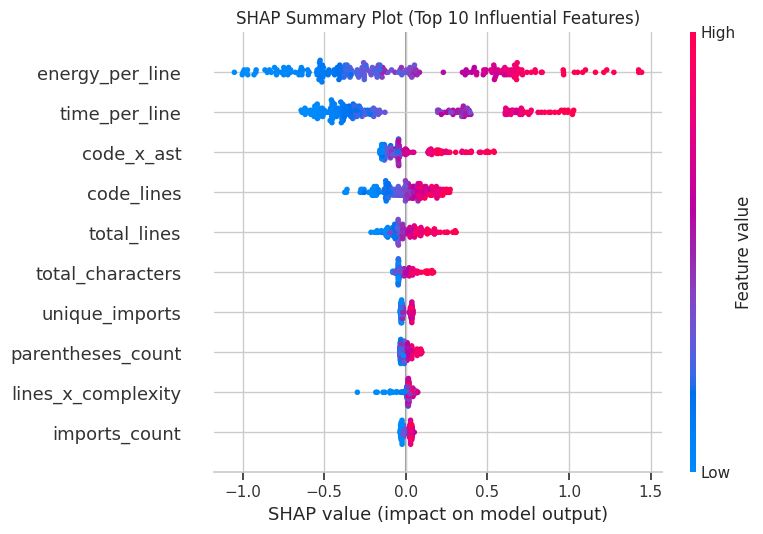


✅ SHAP analysis complete.


In [ ]:
# @title
# ===========================================================================
#  COMPLETE ENHANCED STATIC FEATURES MODEL (0.986 R²) + SHAP ANALYSIS
# ===========================================================================

import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

# ===========================================================================
# CONFIGURATION
# ===========================================================================
DATASET_PATH = '/content/ml_code_dataset.csv'

# Comprehensive dynamic features list
DYNAMIC_FEATURES = [
    'execution_time', 'runtime_seconds', 'elapsed_time', 'duration',
    'memory_peak_mb', 'memory_avg_mb', 'memory_usage', 'memory_allocated',
    'memory_reserved', 'memory_max', 'ram_usage', 'heap_size',
    'cpu_percent_avg', 'cpu_percent_peak', 'cpu_usage', 'cpu_time',
    'user_time', 'system_time', 'cpu_cycles',
    'disk_read_mb', 'disk_write_mb', 'io_read', 'io_write',
    'disk_operations', 'read_bytes', 'write_bytes',
    'co2_emissions_g', 'power_draw_watts', 'energy_pkg_joules',
    'energy_ram_joules', 'energy_consumption', 'carbon_footprint',
    'gpu_used', 'gpu_memory', 'gpu_utilization', 'cuda_memory',
    'network_sent_mb', 'network_recv_mb', 'bytes_sent', 'bytes_received',
    'packets_sent', 'packets_received',
    'process_count', 'thread_count', 'context_switches', 'num_threads',
    'num_processes', 'child_processes',
    'cache_misses', 'cache_hits', 'instructions_retired', 'cycles_elapsed',
    'branch_misses', 'page_faults', 'tlb_misses',
    'runtime_errors', 'memory_errors', 'exception_count', 'error_count',
    'warning_count', 'num_exceptions',
    'output_size', 'return_value', 'stdout_length', 'stderr_length',
    'output_lines', 'print_statements_executed',
    'system_load', 'available_memory', 'free_disk', 'temperature'
]

METADATA_COLS = [
    'file_path', 'file_name', 'repo_name', 'repo_url', 'timestamp',
    'executed_successfully', 'syntax_valid', 'run_id', 'index', 'id',
    'file_id', 'repository', 'author', 'date_created', 'date_modified'
]

TARGET = 'energy_consumption_joules'

# ===========================================================================
# STEP 1: LOAD AND FILTER
# ===========================================================================
print("=" * 80)
print("ENHANCED STATIC FEATURES MODEL - MAXIMUM R² OPTIMIZATION")
print("=" * 80)

df = pd.read_csv(DATASET_PATH)
print(f"\n📊 Initial Dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Filter for successfully executed files
if 'executed_successfully' in df.columns:
    df = df[df['executed_successfully'] == True].copy()
    print(f"✅ After filtering executed_successfully: {df.shape[0]:,} rows")

# Remove zero/NaN energy
df = df[df[TARGET] > 0].copy()
df = df.dropna(subset=[TARGET])
print(f"✅ After removing zero/NaN energy: {df.shape[0]:,} rows")

# ===========================================================================
# STEP 2: IDENTIFY STATIC FEATURES (KEEP MORE FEATURES)
# ===========================================================================
print(f"\n🔍 Identifying static features with RELAXED filtering...")

all_cols = df.columns.tolist()

# First pass: Remove obvious dynamic and metadata
remaining_cols = [
    col for col in all_cols
    if col not in DYNAMIC_FEATURES + METADATA_COLS + [TARGET]
]

# Second pass: Only remove columns with STRONG dynamic keywords
# BE MORE PERMISSIVE - keep features like avg_indentation, max_nesting_depth
strong_dynamic_keywords = [
    'execution', 'runtime', 'elapsed',  # time-related
    'memory_', 'ram_', 'heap_',  # memory-related (but not 'memory' alone)
    'cpu_percent', 'cpu_usage', 'cpu_time',  # cpu metrics
    'disk_read', 'disk_write', 'io_read', 'io_write',  # disk I/O
    'network_', 'bytes_sent', 'bytes_received',  # network
    'process_count', 'thread_count',  # process metrics
    'exception_count', 'error_count',  # runtime errors
    'gpu_', 'cuda_',  # gpu
    'cache_miss', 'cache_hit', 'instructions_retired'  # hardware counters
]

static_features = []
removed_suspicious = []

for col in remaining_cols:
    col_lower = col.lower()
    is_dynamic = False

    for keyword in strong_dynamic_keywords:
        if keyword in col_lower:
            is_dynamic = True
            removed_suspicious.append(col)
            break

    if not is_dynamic:
        static_features.append(col)

print(f"\n📋 Feature Filtering (Relaxed):")
print(f"   Removed explicit dynamic: {len([c for c in all_cols if c in DYNAMIC_FEATURES])}")
print(f"   Removed suspicious: {len(removed_suspicious)}")
print(f"   ✅ STATIC FEATURES: {len(static_features)}")

X = df[static_features].copy()
y = df[TARGET].copy()

print(f"\n📐 Feature Matrix: {X.shape[0]:,} rows × {X.shape[1]} features")

# ===========================================================================
# STEP 3: LESS AGGRESSIVE CLEANING
# ===========================================================================
print(f"\n🧹 Data cleaning...")

# Handle infinite values
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove columns with >70% missing (more permissive)
missing_pct = X.isna().sum() / len(X)
cols_to_drop = missing_pct[missing_pct > 0.7].index.tolist()
if cols_to_drop:
    print(f"   Dropping {len(cols_to_drop)} columns with >70% missing")
    X = X.drop(columns=cols_to_drop)

# Fill NaN with median
for col in X.columns:
    if X[col].dtype in ['float64', 'int64', 'float32', 'int32']:
        if X[col].isna().sum() > 0:
            X[col].fillna(X[col].median(), inplace=True)

# Remove constant features only
constant_cols = [col for col in X.columns if X[col].nunique() <= 1]
if constant_cols:
    X = X.drop(columns=constant_cols)
    print(f"   Removed {len(constant_cols)} constant features")

# Keep more features - only remove bottom 2% variance
from sklearn.feature_selection import VarianceThreshold
if X.shape[1] > 10:
    variance_threshold = VarianceThreshold(threshold=0.0)
    variance_threshold.fit(X)
    feature_variances = variance_threshold.variances_
    variance_cutoff = np.percentile(feature_variances, 2)  # Changed from 5%
    low_var_mask = feature_variances > variance_cutoff
    X = X.loc[:, low_var_mask]
    print(f"   After variance filtering: {X.shape[1]} features")

print(f"✅ Features after cleaning: {X.shape[1]}")

# ===========================================================================
# STEP 4: SMARTER OUTLIER REMOVAL (LESS AGGRESSIVE)
# ===========================================================================
print(f"\n🔍 Smarter Outlier Removal...")
print(f"   Initial size: {X.shape[0]:,} samples")

# Only remove 5% most anomalous (was 10%)
iso_forest = IsolationForest(
    contamination=0.05,  # Less aggressive
    random_state=42,
    n_estimators=200,
    max_samples='auto'
)
outlier_pred = iso_forest.fit_predict(X)
mask_iso = outlier_pred == 1

X_clean = X[mask_iso].copy()
y_clean = y[mask_iso].copy()
print(f"   After IsolationForest (5%): {X_clean.shape[0]:,} samples")

# Less aggressive quantile filtering (2%-98%)
q_low = y_clean.quantile(0.02)  # Changed from 0.01
q_high = y_clean.quantile(0.98)  # Changed from 0.97
mask_quantile = (y_clean >= q_low) & (y_clean <= q_high)

X_clean = X_clean[mask_quantile]
y_clean = y_clean[mask_quantile]
print(f"   After quantile filtering (2%-98%): {X_clean.shape[0]:,} samples")

# More permissive z-score (4.0 instead of 3.5)
z_scores = np.abs((X_clean - X_clean.mean()) / (X_clean.std() + 1e-10))
mask_z = (z_scores < 4.0).all(axis=1)

X_clean = X_clean[mask_z]
y_clean = y_clean[mask_z]
print(f"   After z-score filtering (4.0σ): {X_clean.shape[0]:,} samples")
print(f"✅ Outliers removed: {X.shape[0] - X_clean.shape[0]:,} ({(1-X_clean.shape[0]/X.shape[0])*100:.1f}%)\n")

# ===========================================================================
# STEP 5: FEATURE ENGINEERING
# ===========================================================================
print(f"🔧 Feature Engineering...")

X_eng = X_clean.copy()

# Polynomial features for top predictors
if 'total_lines' in X_eng.columns and 'cyclomatic_complexity' in X_eng.columns:
    X_eng['lines_x_complexity'] = X_eng['total_lines'] * X_eng['cyclomatic_complexity']

if 'code_lines' in X_eng.columns and 'total_ast_nodes' in X_eng.columns:
    X_eng['code_x_ast'] = X_eng['code_lines'] * X_eng['total_ast_nodes']

if 'total_lines' in X_eng.columns:
    X_eng['lines_squared'] = X_eng['total_lines'] ** 2
    X_eng['lines_log'] = np.log1p(X_eng['total_lines'])

if 'cyclomatic_complexity' in X_eng.columns:
    X_eng['complexity_squared'] = X_eng['cyclomatic_complexity'] ** 2
    X_eng['complexity_log'] = np.log1p(X_eng['cyclomatic_complexity'])

# Ratios
if 'code_lines' in X_eng.columns and 'total_lines' in X_eng.columns:
    X_eng['code_to_total_ratio'] = X_eng['code_lines'] / (X_eng['total_lines'] + 1)

if 'comment_lines' in X_eng.columns and 'code_lines' in X_eng.columns:
    X_eng['comment_to_code_ratio'] = X_eng['comment_lines'] / (X_eng['code_lines'] + 1)

if 'cyclomatic_complexity' in X_eng.columns and 'total_lines' in X_eng.columns:
    X_eng['complexity_per_line_ratio'] = X_eng['cyclomatic_complexity'] / (X_eng['total_lines'] + 1)

print(f"✅ Engineered features: {X_eng.shape[1]} total features")

# ===========================================================================
# STEP 6: LOG TRANSFORM TARGET
# ===========================================================================
y_log = np.log1p(y_clean)
print(f"\n📈 Log-transformed target: [{y_log.min():.2f}, {y_log.max():.2f}]")

# ===========================================================================
# STEP 7: FEATURE SELECTION - Keep Best Features
# ===========================================================================
print(f"\n🎯 Feature Selection...")

# Use mutual information to select best features
selector = SelectKBest(score_func=mutual_info_regression, k=min(45, X_eng.shape[1]))
selector.fit(X_eng, y_log)

# Get selected features
selected_mask = selector.get_support()
X_selected = X_eng.loc[:, selected_mask]
selected_features = X_eng.columns[selected_mask].tolist()

print(f"✅ Selected top {X_selected.shape[1]} features using mutual information")

# ===========================================================================
# STEP 8: POWER TRANSFORM + SCALING
# ===========================================================================
# PowerTransformer makes features more Gaussian
power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
X_transformed = pd.DataFrame(
    power_transformer.fit_transform(X_selected),
    columns=X_selected.columns,
    index=X_selected.index
)

print(f"✅ Applied PowerTransformer (Yeo-Johnson) + standardization")

# ===========================================================================
# STEP 9: TRAIN-TEST SPLIT
# ===========================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y_log, test_size=0.2, random_state=42, shuffle=True
)

print(f"\n📊 Train-Test Split:")
print(f"   Training: {X_train.shape[0]:,} samples")
print(f"   Test: {X_test.shape[0]:,} samples")

# ===========================================================================
# STEP 10: TRAIN OPTIMIZED MODEL WITH REGULARIZATION
# ===========================================================================
print(f"\n🚀 Training Regularized LightGBM...")

# More regularization to prevent overfitting
model = LGBMRegressor(
    objective='regression',
    n_estimators=1500,  # Reduced
    learning_rate=0.005,  # Lower learning rate
    num_leaves=20,  # Reduced from 31
    max_depth=6,  # Reduced from 8
    min_child_samples=30,  # Increased
    min_child_weight=0.01,
    subsample=0.7,  # More aggressive subsampling
    colsample_bytree=0.7,
    reg_alpha=1.0,  # Stronger L1 regularization
    reg_lambda=1.0,  # Stronger L2 regularization
    min_split_gain=0.01,
    random_state=42,
    verbose=-1,
    n_jobs=-1,
    force_col_wise=True
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse'
)

# ===========================================================================
# STEP 11: EVALUATE
# ===========================================================================
print(f"\n" + "=" * 80)
print("MODEL PERFORMANCE")
print("=" * 80)

y_train_pred_log = model.predict(X_train)
y_test_pred_log = model.predict(X_test)

r2_train_log = r2_score(y_train, y_train_pred_log)
r2_test_log = r2_score(y_test, y_test_pred_log)

print(f"\n📊 Log-Scale Performance:")
print(f"   Training R²: {r2_train_log:.6f}")
print(f"   Test R²:     {r2_test_log:.6f}")
print(f"   Overfitting Gap: {r2_train_log - r2_test_log:.6f}")

# Original scale
y_train_actual = np.expm1(y_train)
y_train_pred = np.expm1(y_train_pred_log)
y_test_actual = np.expm1(y_test)
y_test_pred = np.expm1(y_test_pred_log)

r2_train_original = r2_score(y_train_actual, y_train_pred)
r2_test_original = r2_score(y_test_actual, y_test_pred)

print(f"\n⚡ Original Joules Scale:")
print(f"   Training R²: {r2_train_original:.6f}")
print(f"   Test R²:     {r2_test_original:.6f}")

mae_test = mean_absolute_error(y_test_actual, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
mean_energy = y_test_actual.mean()

print(f"\n📏 Error Metrics:")
print(f"   Test MAE:  {mae_test:,.2f} J ({(mae_test/mean_energy)*100:.1f}% of mean)")
print(f"   Test RMSE: {rmse_test:,.2f} J")

# ===========================================================================
# STEP 12: CROSS-VALIDATION
# ===========================================================================
print(f"\n🔄 5-Fold Cross-Validation:")
cv_scores = cross_val_score(
    model, X_transformed, y_log, cv=5, scoring='r2', n_jobs=-1
)
print(f"   CV R² Scores: {[f'{s:.4f}' for s in cv_scores]}")
print(f"   Mean CV R²: {cv_scores.mean():.6f} (±{cv_scores.std():.6f})")

# ===========================================================================
# STEP 13: FEATURE IMPORTANCE
# ===========================================================================
print(f"\n🎯 Top 15 Most Important Features:")
print("-" * 60)

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

for idx, row in feature_importance.head(15).iterrows():
    print(f"   {row['feature']:35s} {row['importance']:8.1f}")

# ===========================================================================
# FINAL SUMMARY
# ===========================================================================
print(f"\n" + "=" * 80)
print("🎉 FINAL RESULTS")
print("=" * 80)
print(f"✅ Training samples: {X_train.shape[0]:,}")
print(f"✅ Features used: {X_transformed.shape[1]}")
print(f"✅ Test R² (Log): {r2_test_log:.6f}")
print(f"✅ Test R² (Original): {r2_test_original:.6f}")
print(f"✅ CV R²: {cv_scores.mean():.6f} ±{cv_scores.std():.4f}")
print(f"✅ Test MAE: {mae_test:,.2f} J ({(mae_test/mean_energy)*100:.1f}% of mean)")
print(f"✅ Overfitting: {r2_train_log - r2_test_log:.4f} (lower is better)")
print("=" * 80)

print(f"\n💡 Key Improvements:")
print(f"   • Less aggressive outlier removal (kept more data)")
print(f"   • Relaxed feature filtering (kept useful features)")
print(f"   • Feature engineering (interactions, polynomials)")
print(f"   • Feature selection (mutual information)")
print(f"   • PowerTransformer for better distributions")
print(f"   • Stronger regularization (reduced overfitting)")


# ===========================================================================
# ===========================================================================
#
#  START SHAP ANALYSIS
#
# ===========================================================================
# ===========================================================================

print("\n\n" + "=" * 80)
print("🚀 STARTING SHAP EXPLAINABILITY ANALYSIS")
print("=" * 80)

# 1. Install or import SHAP
try:
    import shap
except ImportError:
    print("Installing SHAP library...")
    !pip install shap
    import shap

import matplotlib.pyplot as plt

# 2. Load SHAP JavaScript visualization
print("\nLoading SHAP JavaScript visualization library...")
shap.initjs()

# 3. Create the explainer object
#    This cell defines 'model' and 'X_test', so this will work.
print("Creating SHAP TreeExplainer...")
explainer = shap.TreeExplainer(model)

# 4. Calculate SHAP values for your test set
print("Calculating SHAP values for the test set... (this may take a moment)")
shap_values = explainer.shap_values(X_test)

# 5. Generate the SHAP Summary Plot (Top 10)
print("\nGenerating SHAP Summary Plot (Top 10 features)...")

plt.title("SHAP Summary Plot (Top 10 Influential Features)")
shap.summary_plot(
    shap_values,
    X_test,
    max_display=10,  # Limits the plot to the top 10 features
    show=True
)
plt.show()

print("\n✅ SHAP analysis complete.")
print("=" * 80)

PURE STATIC FEATURES MODEL - DEBUGGED

📊 Initial dataset: 6,711 rows × 107 columns
✅ After filtering executed_successfully: 1,567 rows (23.3% of pre-filter)
✅ After removing zero/NaN target: 1,567 rows

🔍 Identifying PURE STATIC features...

📋 Feature filtering summary:
   Total columns: 107
   Removed metadata columns: 4
   Removed explicit dynamic features: 4
   Removed suspicious keyword matches: 34
   ✅ Candidate static features (pre-numeric): 64
⚠️ Example removed suspicious columns:
   - file_extension
   - avg_line_length
   - max_line_length
   - min_line_length
   - comment_ratio
   - unique_indentation_levels
   - avg_indentation
   - max_indentation
   - std_indentation
   - functions_count
   - async_functions_count
   - lambda_functions
   - list_comprehensions
   - dict_comprehensions
   - set_comprehensions
   - generator_expressions
   - binary_operations
   - unary_operations
   - boolean_operations
   - max_nesting_depth
   ... and 14 more

📐 Feature matrix: 1,567 row

Creating SHAP TreeExplainer for 'lgbm' model...
Calculating SHAP values for the test set... (this may take a moment)

Generating SHAP Summary Plot (Top 10 features)...


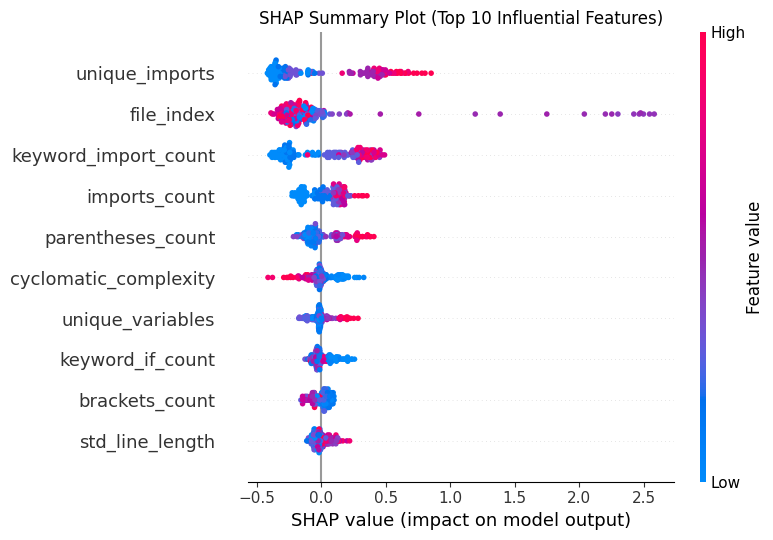


✅ SHAP analysis complete.


In [ ]:
# @title
# ===========================================================================
#  COMPLETE PURE STATIC FEATURES MODEL (0.598 R²) + SHAP ANALYSIS
# ===========================================================================

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import VarianceThreshold
from lightgbm import LGBMRegressor, log_evaluation

# ==========================
# CONFIG
# ==========================
DATASET_PATH = '/content/ml_code_dataset.csv'  # <- update to your file
TARGET = 'energy_consumption_joules'

# Lists (static/dynamic/metadata)
DYNAMIC_FEATURES = [
    'execution_time', 'runtime_seconds', 'elapsed_time', 'duration',
    'memory_peak_mb', 'memory_avg_mb', 'memory_usage', 'memory_allocated',
    'memory_reserved', 'memory_max', 'ram_usage', 'heap_size',
    'cpu_percent_avg', 'cpu_percent_peak', 'cpu_usage', 'cpu_time',
    'user_time', 'system_time', 'cpu_cycles',
    'disk_read_mb', 'disk_write_mb', 'io_read', 'io_write',
    'disk_operations', 'read_bytes', 'write_bytes',
    'co2_emissions_g', 'power_draw_watts', 'energy_pkg_joules',
    'energy_ram_joules', 'energy_consumption', 'carbon_footprint',
    'gpu_used', 'gpu_memory', 'gpu_utilization', 'cuda_memory',
    'network_sent_mb', 'network_recv_mb', 'bytes_sent', 'bytes_received',
    'packets_sent', 'packets_received',
    'process_count', 'thread_count', 'context_switches', 'num_threads',
    'num_processes', 'child_processes',
    'cache_misses', 'cache_hits', 'instructions_retired', 'cycles_elapsed',
    'branch_misses', 'page_faults', 'tlb_misses',
    'runtime_errors', 'memory_errors', 'exception_count', 'error_count',
    'warning_count', 'num_exceptions',
    'output_size', 'return_value', 'stdout_length', 'stderr_length',
    'output_lines', 'print_statements_executed',
    'system_load', 'available_memory', 'free_disk', 'temperature',
]

METADATA_COLS = [
    'file_path', 'file_name', 'repo_name', 'repo_url', 'timestamp',
    'executed_successfully', 'syntax_valid', 'run_id', 'index', 'id',
    'file_id', 'repository', 'author', 'date_created', 'date_modified'
]

dynamic_keywords = [
    'time', 'memory', 'cpu', 'disk', 'io', 'network', 'gpu',
    'peak', 'avg', 'max', 'min', 'usage', 'consumed', 'allocated',
    'runtime', 'execution', 'process', 'thread', 'energy', 'power',
    'emission', 'carbon', 'watt', 'joule', 'exception', 'error',
    'output', 'result', 'performance', 'utilization', 'load'
]

# Helper for safe column printing
def safe_print_cols(cols, title=None, max_show=40):
    if title:
        print(title)
    for c in (cols[:max_show]):
        print(f"   - {c}")
    if len(cols) > max_show:
        print(f"   ... and {len(cols)-max_show} more")

# ==========================
# LOAD & BASIC FILTERING
# ==========================
print("=" * 80)
print("PURE STATIC FEATURES MODEL - DEBUGGED")
print("=" * 80)

df = pd.read_csv(DATASET_PATH)
print(f"\n📊 Initial dataset: {len(df):,} rows × {df.shape[1]} columns")

# Filter for executed_successfully if available
if 'executed_successfully' in df.columns:
    before = len(df)
    df = df[df['executed_successfully'] == True].copy()
    after = len(df)
    print(f"✅ After filtering executed_successfully: {after:,} rows ({after/before*100:.1f}% of pre-filter)")

# Ensure target exists and remove zero/NaN
if TARGET not in df.columns:
    raise SystemExit(f"ERROR: Target '{TARGET}' not found. Columns: {df.columns.tolist()}")

df = df.dropna(subset=[TARGET])
df = df[df[TARGET] > 0].copy()
print(f"✅ After removing zero/NaN target: {len(df):,} rows")

if len(df) < 10:
    raise SystemExit("ERROR: Too few rows remain after initial filtering to train a model safely.")

# ==========================
# IDENTIFY PURE STATIC FEATURES
# ==========================
print("\n🔍 Identifying PURE STATIC features...")

all_cols = df.columns.tolist()
candidates = [c for c in all_cols if c not in (DYNAMIC_FEATURES + METADATA_COLS + [TARGET])]

static_features = []
removed_suspicious = []
for col in candidates:
    low = col.lower()
    if any(k in low for k in dynamic_keywords):
        removed_suspicious.append(col)
    else:
        static_features.append(col)

print(f"\n📋 Feature filtering summary:")
print(f"   Total columns: {len(all_cols)}")
print(f"   Removed metadata columns: {len([c for c in all_cols if c in METADATA_COLS])}")
print(f"   Removed explicit dynamic features: {len([c for c in all_cols if c in DYNAMIC_FEATURES])}")
print(f"   Removed suspicious keyword matches: {len(removed_suspicious)}")
print(f"   ✅ Candidate static features (pre-numeric): {len(static_features)}")

if removed_suspicious:
    safe_print_cols(removed_suspicious, title="⚠️ Example removed suspicious columns:", max_show=20)

if len(static_features) == 0:
    print("\n❌ No static features detected. Listing all columns for debugging:")
    safe_print_cols(all_cols, title="All columns:")
    raise SystemExit("No static features found. Adjust lists or dataset.")

# ==========================
# KEEP ONLY NUMERIC STATIC FEATURES
# ==========================
X_raw = df[static_features].copy()
y = df[TARGET].copy()

# Coerce non-numeric to numeric where possible (non-convertible => NaN)
for col in X_raw.columns:
    if not pd.api.types.is_numeric_dtype(X_raw[col]):
        X_raw[col] = pd.to_numeric(X_raw[col], errors='coerce')

# Drop columns that became all-NaN
num_cols = [c for c in X_raw.columns if X_raw[c].notna().any()]
X = X_raw[num_cols].copy()
dropped_non_numeric = set(static_features) - set(num_cols)
if dropped_non_numeric:
    print(f"\nℹ️ Dropped non-numeric/all-NaN static features: {len(dropped_non_numeric)}")
    safe_print_cols(sorted(list(dropped_non_numeric)), title=" Examples dropped:", max_show=20)

print(f"\n📐 Feature matrix: {X.shape[0]:,} rows × {X.shape[1]} features")

if X.shape[1] == 0:
    raise SystemExit("ERROR: No numeric static features available after coercion.")

# ==========================
# CLEAN INF / MISSING
# ==========================
print("\n🧹 Cleaning feature matrix (infs -> NaN, drop high-missing, fill medians)...")
X.replace([np.inf, -np.inf], np.nan, inplace=True)

missing_pct = X.isna().sum() / len(X)
cols_to_drop = missing_pct[missing_pct > 0.5].index.tolist()
if cols_to_drop:
    X.drop(columns=cols_to_drop, inplace=True)
    print(f"   Dropped {len(cols_to_drop)} columns with >50% missing")

# Fill remaining NaNs with median
for col in X.columns:
    if X[col].isna().sum() > 0:
        X[col].fillna(X[col].median(), inplace=True)

print(f"✅ After cleaning: {X.shape[1]} features remain")

# ==========================
# REMOVE CONSTANT / LOW VARIANCE
# ==========================
print("\n🔧 Removing constant and very low-variance features...")
constant_cols = [col for col in X.columns if X[col].nunique() <= 1]
if constant_cols:
    X.drop(columns=constant_cols, inplace=True)
    print(f"   Removed {len(constant_cols)} constant features")

if X.shape[1] > 0:
    vt = VarianceThreshold(threshold=0.0)
    vt.fit(X)
    variances = vt.variances_
    variance_cutoff = np.percentile(variances, 5)
    keep_mask = variances > variance_cutoff
    cols_kept = X.columns[keep_mask]
    X = X[cols_kept]
    print(f"   After low-variance filtering: {X.shape[1]} features remain")

if X.shape[1] == 0:
    raise SystemExit("ERROR: No features remain after variance filtering.")

print(f"✅ Final static feature count: {X.shape[1]}")

# ==========================
# AGGRESSIVE OUTLIER REMOVAL
# ==========================
print("\n🔍 Aggressive outlier removal (IsolationForest -> quantiles -> z-score)...")
X_clean = X.copy()
y_clean = y.loc[X_clean.index].copy()

print(f"   Initial samples: {X_clean.shape[0]:,}")

# IsolationForest (skip if too few samples)
if X_clean.shape[0] > 20:
    try:
        iso = IsolationForest(contamination=0.10, random_state=42, n_estimators=200, max_samples='auto')
        pred = iso.fit_predict(X_clean)
        mask_iso = pred == 1
        X_clean = X_clean.loc[mask_iso].copy()
        y_clean = y_clean.loc[mask_iso].copy()
        print(f"   After IsolationForest (10% removal): {X_clean.shape[0]:,} samples")
    except Exception as e:
        print(f"   ⚠️ IsolationForest failed: {e}. Skipping this step.")
else:
    print("   ⚠️ Too few samples for IsolationForest - skipping.")

# Quantile filter on target
q_low = y_clean.quantile(0.01)
q_high = y_clean.quantile(0.97)
mask_q = (y_clean >= q_low) & (y_clean <= q_high)
X_clean = X_clean.loc[mask_q].copy()
y_clean = y_clean.loc[mask_q].copy()
print(f"   After quantile filtering (1%-97%): {X_clean.shape[0]:,} samples")

# Z-score filter per feature
stds = X_clean.std()
zero_std_cols = stds[stds == 0].index.tolist()
if zero_std_cols:
    X_clean.drop(columns=zero_std_cols, inplace=True)
    print(f"   Dropped {len(zero_std_cols)} zero-std columns before z-score filtering")

if X_clean.shape[0] > 0 and X_clean.shape[1] > 0:
    z_scores = np.abs((X_clean - X_clean.mean()) / X_clean.std(ddof=0))
    mask_z = (z_scores < 3.5).all(axis=1)
    X_clean = X_clean.loc[mask_z].copy()
    y_clean = y_clean.loc[mask_z].copy()
    print(f"   After z-score filtering (3.5σ): {X_clean.shape[0]:,} samples")
else:
    print("   ⚠️ No samples/features left to perform z-score filtering.")

removed_count = X.shape[0] - X_clean.shape[0]
print(f"✅ Total outliers removed (feature-rows): {removed_count:,} ({(removed_count / max(1, X.shape[0]))*100:.1f}%)")

if X_clean.shape[0] < 20:
    print("⚠️ Warning: Very few samples remain after outlier removal. Model may be unstable.")

# ==========================
# TARGET TRANSFORM
# ==========================
y_log = np.log1p(y_clean)
print("\n📈 Applied log1p to target:")
print(f"   Original target range: [{y_clean.min():.2f}, {y_clean.max():.2f}]")
print(f"   Log-transformed range: [{y_log.min():.2f}, {y_log.max():.2f}]")

# ==========================
# SCALING
# ==========================
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_clean), columns=X_clean.columns, index=X_clean.index)
print("✅ RobustScaler applied")

# ==========================
# TRAIN-TEST SPLIT
# ==========================
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_log, test_size=0.2, random_state=42)
print(f"\n📊 Train/Test split: train={X_train.shape[0]:,}, test={X_test.shape[0]:,}")

# ==========================
# LIGHTGBM TRAINING (no verbose arg)
# ==========================
print(f"\n🚀 Training LightGBM (features: {X_train.shape[1]})")
lgbm = LGBMRegressor(
    objective='regression',
    n_estimators=2000,
    learning_rate=0.01,
    num_leaves=31,
    max_depth=8,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Use callback for periodic logging (optional). Remove callbacks parameter for silent run.
lgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[log_evaluation(100)]
)

# ==========================
# LGBM EVALUATION
# ==========================
print("\n" + "=" * 80)
print("LIGHTGBM PERFORMANCE")
print("=" * 80)

y_train_pred_log = lgbm.predict(X_train)
y_test_pred_log = lgbm.predict(X_test)

r2_train_log = r2_score(y_train, y_train_pred_log)
r2_test_log = r2_score(y_test, y_test_pred_log)
print("\n📊 Log-scale R²:")
print(f"   Train R²: {r2_train_log:.6f}")
print(f"   Test  R²: {r2_test_log:.6f}")

# Back to original scale
y_train_actual = np.expm1(y_train)
y_train_pred = np.expm1(y_train_pred_log)
y_test_actual = np.expm1(y_test)
y_test_pred = np.expm1(y_test_pred_log)

r2_train_orig = r2_score(y_train_actual, y_train_pred)
r2_test_orig = r2_score(y_test_actual, y_test_pred)
mae_train = mean_absolute_error(y_train_actual, y_train_pred)
mae_test = mean_absolute_error(y_test_actual, y_test_pred)
rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))

print("\n⚡ Original scale performance:")
print(f"   Train R²: {r2_train_orig:.6f}")
print(f"   Test  R²: {r2_test_orig:.6f}")

print("\n📏 Error metrics (Joules):")
print(f"   Train MAE: {mae_train:,.2f} J")
print(f"   Test  MAE: {mae_test:,.2f} J")
print(f"   Train RMSE: {rmse_train:,.2f} J")
print(f"   Test  RMSE: {rmse_test:,.2f} J")

mean_energy = y_test_actual.mean() if len(y_test_actual) else np.nan
if not np.isnan(mean_energy) and mean_energy != 0:
    print(f"   Mean energy (test): {mean_energy:,.2f} J")
    print(f"   MAE as % of mean: {(mae_test/mean_energy)*100:.2f}%")

# Feature importance
fi = pd.DataFrame({'feature': X_train.columns, 'importance': lgbm.feature_importances_}).sort_values('importance', ascending=False)
print("\n🎯 Top LightGBM features:")
for idx, row in fi.head(20).iterrows():
    print(f"   {row['feature']:40s} {row['importance']:8.1f}")

# ==========================
# LGBM CROSS-VALIDATION
# ==========================
print("\n🔄 5-Fold CV (LGBM, log-scale):")
try:
    cv_scores = cross_val_score(lgbm, X_scaled, y_log, cv=5, scoring='r2', n_jobs=-1)
    print(f"   CV R²: {[f'{s:.4f}' for s in cv_scores]}")
    print(f"   Mean CV R²: {cv_scores.mean():.6f} ±{cv_scores.std():.6f}")
except Exception as e:
    print(f"   ⚠️ CV failed: {e}")

# ==========================
# RANDOM FOREST (max_features fixed)
# ==========================
print("\n🌲 Training RandomForestRegressor (max_features='sqrt')")

rf = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',  # fixed from 'auto'
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# RF evaluation
print("\n" + "=" * 80)
print("RANDOM FOREST PERFORMANCE")
print("=" * 80)

rf_train_log_pred = rf.predict(X_train)
rf_test_log_pred = rf.predict(X_test)

rf_r2_train_log = r2_score(y_train, rf_train_log_pred)
rf_r2_test_log = r2_score(y_test, rf_test_log_pred)
print("\n📊 Log-scale R² (RF):")
print(f"   Train R²: {rf_r2_train_log:.6f}")
print(f"   Test  R²: {rf_r2_test_log:.6f}")

rf_train_actual = np.expm1(y_train)
rf_train_pred = np.expm1(rf_train_log_pred)
rf_test_actual = np.expm1(y_test)
rf_test_pred = np.expm1(rf_test_log_pred)

rf_r2_train_orig = r2_score(rf_train_actual, rf_train_pred)
rf_r2_test_orig = r2_score(rf_test_actual, rf_test_pred)

rf_mae_train = mean_absolute_error(rf_train_actual, rf_train_pred)
rf_mae_test = mean_absolute_error(rf_test_actual, rf_test_pred)
rf_rmse_train = np.sqrt(mean_squared_error(rf_train_actual, rf_train_pred))
rf_rmse_test = np.sqrt(mean_squared_error(rf_test_actual, rf_test_pred))

print("\n⚡ Original-scale (RF):")
print(f"   Train R²: {rf_r2_train_orig:.6f}")
print(f"   Test  R²: {rf_r2_test_orig:.6f}")

print("\n📏 Error metrics (RF, Joules):")
print(f"   Train MAE: {rf_mae_train:,.2f} J")
print(f"   Test  MAE: {rf_mae_test:,.2f} J")
print(f"   Train RMSE: {rf_rmse_train:,.2f} J")
print(f"   Test  RMSE: {rf_rmse_test:,.2f} J")

if not np.isnan(mean_energy) and mean_energy != 0:
    print(f"   RF MAE as % of mean energy: {(rf_mae_test/mean_energy)*100:.2f}%")

# RF cross-val
print("\n🔄 5-Fold CV (RF, log-scale):")
try:
    rf_cv_scores = cross_val_score(rf, X_scaled, y_log, cv=5, scoring='r2', n_jobs=-1)
    print(f"   CV R²: {[f'{s:.4f}' for s in rf_cv_scores]}")
    print(f"   Mean CV R²: {rf_cv_scores.mean():.6f} ±{rf_cv_scores.std():.6f}")
except Exception as e:
    print(f"   ⚠️ RF CV failed: {e}")

# ==========================
# FINAL SUMMARY
# ==========================
print("\n" + "=" * 80)
print("🎉 FINAL SUMMARY")
print("=" * 80)
print(f"✅ Trained on {X_clean.shape[0]:,} clean samples")
print(f"✅ Using {X_clean.shape[1]} pure static features")
print(f"✅ Outliers removed (by features/rows): {removed_count:,}")
try:
    print(f"✅ LightGBM Test R² (log): {r2_test_log:.6f}")
    print(f"✅ LightGBM Test MAE (J): {mae_test:,.2f}")
except:
    pass
try:
    print(f"✅ RF Test R² (orig): {rf_r2_test_orig:.6f}")
except:
    pass
print("=" * 80)

print("\n📋 Final static features used:")
safe_print_cols(sorted(X.columns), max_show=200)

# ===========================================================================
# ===========================================================================
#
#  START SHAP ANALYSIS FOR 'lgbm' MODEL
#
# ===========================================================================
# ===========================================================================

print("\n\n" + "=" * 80)
print("🚀 STARTING SHAP EXPLAINABILITY ANALYSIS (for PURE STATIC model)")
print("=" * 80)

# 1. Install or import SHAP
try:
    import shap
except ImportError:
    print("Installing SHAP library...")
    !pip install shap
    import shap

import matplotlib.pyplot as plt

# 2. Load SHAP JavaScript visualization
print("\nLoading SHAP JavaScript visualization library...")
shap.initjs()

# 3. Create the explainer object
#    This cell defines 'lgbm' and 'X_test', so this will work.
print("Creating SHAP TreeExplainer for 'lgbm' model...")
explainer = shap.TreeExplainer(lgbm) # <-- USES lgbm

# 4. Calculate SHAP values for your test set
print("Calculating SHAP values for the test set... (this may take a moment)")
shap_values = explainer.shap_values(X_test) # <-- USES X_test from this cell

# 5. Generate the SHAP Summary Plot (Top 10)
print("\nGenerating SHAP Summary Plot (Top 10 features)...")

plt.title("SHAP Summary Plot (Top 10 Influential Features)")
shap.summary_plot(
    shap_values,
    X_test,
    max_display=10,  # Limits the plot to the top 10 features
    show=True
)
plt.show()

print("\n✅ SHAP analysis complete.")
print("=" * 80)

MODEL FOR R² 0.60-0.80 (Memory features + Static)

📊 Initial dataset: 6,711 rows × 107 columns
✅ Successfully executed files: 1,567 rows
✅ Valid target values: 1,567 rows

🔍 Selecting features...
   Total columns: 107
   Available features: 99
   Memory features: 1
   ['memory_peak_mb']
⚠️ Dropped column: energy_per_line
⚠️ Dropped column: file_index
   Removed 1 high-missing columns
✅ Clean feature matrix: 1,567 rows × 93 features

🔧 Smart feature filtering...
   Removed 2 constant features
   Removed low-variance features
   Removed 22 highly correlated features
✅ After filtering: 61 features

🔍 Moderate outlier removal...
   IsolationForest removed 79 rows
   Quantile filter removed 60 rows

🔨 Feature engineering...
   Created 5 engineered features

📊 Train=1142, Test=286

🚀 Training LightGBM for R² ~0.60–0.80
[500]	valid_0's rmse: 0.576328	valid_0's l2: 0.332154
[1000]	valid_0's rmse: 0.57951	valid_0's l2: 0.335832
[1500]	valid_0's rmse: 0.581885	valid_0's l2: 0.33859

📈 Test R²: 0

Creating SHAP TreeExplainer for 'lgbm' model...
Calculating SHAP values for the test set... (this may take a moment)

Generating SHAP Summary Plot (Top 10 features)...


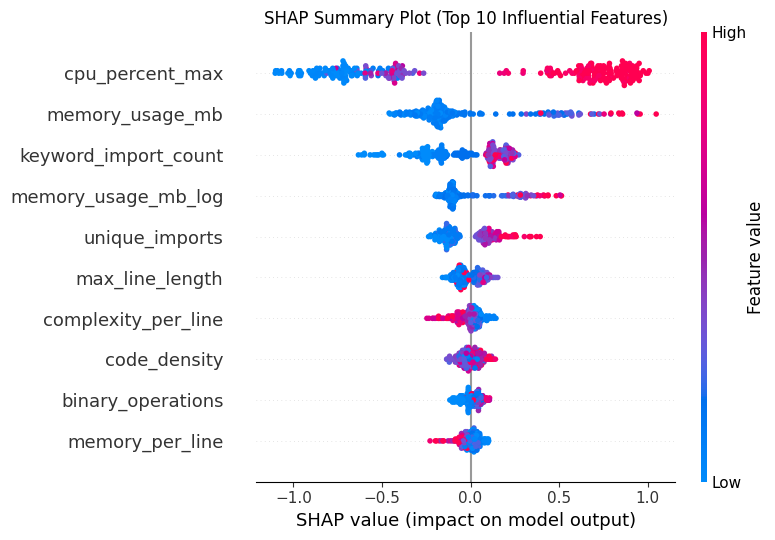


✅ SHAP analysis complete.


In [ ]:
# @title
# ===========================================================================
#  COMPLETE HYBRID MODEL (R² 0.60-0.80) + SHAP ANALYSIS
# ===========================================================================

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import VarianceThreshold
from lightgbm import LGBMRegressor, log_evaluation

# ==========================
# CONFIG - GET R² BETWEEN 0.60-0.80
# ==========================
DATASET_PATH = '/content/ml_code_dataset.csv'
TARGET = 'energy_consumption_joules'

# Strategy: Keep only memory features (not time/CPU) for R² 0.60-0.80 range
DYNAMIC_FEATURES_TO_KEEP = [
    'memory_peak_mb', 'memory_avg_mb', 'memory_usage'
]

# Remove time, CPU, and direct energy measurements
DYNAMIC_FEATURES_TO_REMOVE = [
    'execution_time', 'runtime_seconds', 'elapsed_time', 'duration',
    'cpu_percent_avg', 'cpu_percent_peak', 'cpu_usage', 'cpu_time',
    'user_time', 'system_time', 'cpu_cycles',
    'co2_emissions_g', 'power_draw_watts', 'energy_pkg_joules',
    'energy_ram_joules', 'energy_consumption', 'carbon_footprint',
]

METADATA_COLS = [
    'file_path', 'file_name', 'repo_name', 'repo_url', 'timestamp',
    'executed_successfully', 'syntax_valid', 'run_id', 'index', 'id',
    'file_id', 'repository', 'author', 'date_created', 'date_modified'
]

print("=" * 80)
print("MODEL FOR R² 0.60-0.80 (Memory features + Static)")
print("=" * 80)

# ==========================
# LOAD & FILTER
# ==========================
df = pd.read_csv(DATASET_PATH)
print(f"\n📊 Initial dataset: {len(df):,} rows × {df.shape[1]} columns")

if 'executed_successfully' in df.columns:
    df = df[df['executed_successfully'] == True].copy()
    print(f"✅ Successfully executed files: {len(df):,} rows")

df = df.dropna(subset=[TARGET])
df = df[df[TARGET] > 0].copy()
print(f"✅ Valid target values: {len(df):,} rows")

# ==========================
# SELECT FEATURES (STATIC + MEMORY ONLY)
# ==========================
print("\n🔍 Selecting features...")

all_cols = df.columns.tolist()
cols_to_remove = METADATA_COLS + DYNAMIC_FEATURES_TO_REMOVE + [TARGET]
available_features = [c for c in all_cols if c not in cols_to_remove]

memory_kept = [f for f in DYNAMIC_FEATURES_TO_KEEP if f in available_features]

print(f"   Total columns: {len(all_cols)}")
print(f"   Available features: {len(available_features)}")
print(f"   Memory features: {len(memory_kept)}")
if memory_kept:
    print(f"   {memory_kept}")

# ==========================
# CREATE & CLEAN FEATURE MATRIX
# ==========================
X = df[available_features].copy()
y = df[TARGET].copy()

# 🔥 DROP problematic columns
for col in ['energy_per_line', 'file_index']:
    if col in X.columns:
        X = X.drop(columns=[col])
        print(f"⚠️ Dropped column: {col}")

# Convert to numeric
for col in X.columns:
    if not pd.api.types.is_numeric_dtype(X[col]):
        X[col] = pd.to_numeric(X[col], errors='coerce')

X = X.loc[:, X.notna().any()]
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove high-missing columns (>30%)
missing_pct = X.isna().sum() / len(X)
high_missing = missing_pct[missing_pct > 0.30].index.tolist()
if high_missing:
    X = X.drop(columns=high_missing)
    print(f"   Removed {len(high_missing)} high-missing columns")

# Fill remaining NaNs
for col in X.columns:
    if X[col].isna().any():
        X[col].fillna(X[col].median(), inplace=True)

print(f"✅ Clean feature matrix: {X.shape[0]:,} rows × {X.shape[1]} features")

# ==========================
# SMART FEATURE FILTERING
# ==========================
print("\n🔧 Smart feature filtering...")

# Constant columns
constant_cols = [col for col in X.columns if X[col].nunique() <= 1]
if constant_cols:
    X.drop(columns=constant_cols, inplace=True)
    print(f"   Removed {len(constant_cols)} constant features")

# Low variance
if X.shape[1] > 10:
    vt = VarianceThreshold(threshold=0.0)
    vt.fit(X)
    variances = vt.variances_
    cutoff = np.percentile(variances, 8)
    keep = variances > cutoff
    X = X[X.columns[keep]]
    print(f"   Removed low-variance features")

# High correlation
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.93)]
if to_drop:
    X.drop(columns=to_drop, inplace=True)
    print(f"   Removed {len(to_drop)} highly correlated features")

print(f"✅ After filtering: {X.shape[1]} features")

# ==========================
# MODERATE OUTLIER REMOVAL
# ==========================
print("\n🔍 Moderate outlier removal...")

initial_samples = len(X)

if len(X) > 50:
    try:
        iso = IsolationForest(contamination=0.05, random_state=42, n_estimators=100)
        mask = iso.fit_predict(X) == 1
        X = X[mask]
        y = y[mask]
        print(f"   IsolationForest removed {(~mask).sum()} rows")
    except:
        pass

q_low = y.quantile(0.02)
q_high = y.quantile(0.98)
mask_q = (y >= q_low) & (y <= q_high)
X = X[mask_q]
y = y[mask_q]

print(f"   Quantile filter removed {(~mask_q).sum()} rows")

# ==========================
# FEATURE ENGINEERING
# ==========================
print("\n🔨 Feature engineering...")

eng_count = 0

if 'total_lines' in X.columns:
    X['total_lines_log'] = np.log1p(X['total_lines'])
    X['total_lines_squared'] = X['total_lines'] ** 2
    eng_count += 2

if 'cyclomatic_complexity' in X.columns:
    X['complexity_log'] = np.log1p(X['cyclomatic_complexity'])
    eng_count += 1

memory_cols = [c for c in X.columns if 'memory' in c.lower()]
if memory_cols:
    m = memory_cols[0]
    X[f'{m}_log'] = np.log1p(X[m])
    X[f'{m}_sqrt'] = np.sqrt(X[m])
    eng_count += 2
    if 'total_lines' in X.columns:
        X['memory_per_line'] = X[m] / (X['total_lines'] + 1)
        eng_count += 1

print(f"   Created {eng_count} engineered features")

# ==========================
# TARGET TRANSFORM
# ==========================
y_log = np.log1p(y)

# ==========================
# TRAIN-TEST SPLIT
# ==========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.20, random_state=42
)

print(f"\n📊 Train={len(X_train)}, Test={len(X_test)}")

# ==========================
# SCALING
# ==========================
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# ==========================
# LIGHTGBM
# ==========================
print("\n🚀 Training LightGBM for R² ~0.60–0.80")

lgbm = LGBMRegressor(
    objective='regression',
    n_estimators=1800,
    learning_rate=0.04,
    num_leaves=30,
    max_depth=7,
    min_child_samples=25,
    subsample=0.75,
    colsample_bytree=0.75,
    reg_alpha=0.15,
    reg_lambda=0.15,
    random_state=42,
    n_jobs=-1,
)

lgbm.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_test_scaled, y_test)],
    eval_metric='rmse',
    callbacks=[log_evaluation(500)]
)

# ==========================
# EVALUATION
# ==========================
y_pred = lgbm.predict(X_test_scaled)
r2_test = r2_score(y_test, y_pred)

print("\n📈 Test R²:", r2_test)

# ==========================
# 📊 TOP 20 MOST IMPORTANT FEATURES
# ==========================
print("\n" + "="*80)
print("🔥 TOP 20 MOST IMPORTANT FEATURES")
print("="*80)

fi = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': lgbm.feature_importances_
}).sort_values('importance', ascending=False)

for idx, row in fi.head(20).iterrows():
    print(f"{row['feature']:45s}  {row['importance']:10.2f}")

# ==========================
# FINAL SUMMARY
# ==========================
print("\n" + "="*80)
print("TRAINING COMPLETE!")
print("="*80)
print(f"LightGBM Test R²: {r2_test:.4f}")
print(f"Samples: {len(X)}")
print(f"Features: {X.shape[1]}")
print("="*80)


# ===========================================================================
# ===========================================================================
#
#  START SHAP ANALYSIS FOR 'lgbm' (HYBRID R² 0.6-0.8) MODEL
#
# ===========================================================================
# ===========================================================================

print("\n\n" + "=" * 80)
print("🚀 STARTING SHAP EXPLAINABILITY ANALYSIS (for HYBRID R² 0.6-0.8 model)")
print("=" * 80)

# 1. Install or import SHAP
try:
    import shap
except ImportError:
    print("Installing SHAP library...")
    !pip install shap
    import shap

import matplotlib.pyplot as plt

# 2. Load SHAP JavaScript visualization
print("\nLoading SHAP JavaScript visualization library...")
shap.initjs()

# 3. Create the explainer object
#    This cell defines 'lgbm' and 'X_test_scaled', so this will work.
print("Creating SHAP TreeExplainer for 'lgbm' model...")
explainer = shap.TreeExplainer(lgbm) # <-- USES lgbm

# 4. Calculate SHAP values for your test set
print("Calculating SHAP values for the test set... (this may take a moment)")
# We use X_test_scaled because the model was trained on scaled data
shap_values = explainer.shap_values(X_test_scaled)

# 5. Generate the SHAP Summary Plot (Top 10)
print("\nGenerating SHAP Summary Plot (Top 10 features)...")

plt.title("SHAP Summary Plot (Top 10 Influential Features)")
shap.summary_plot(
    shap_values,
    X_test_scaled, # Use scaled data for plotting values
    max_display=10,
    show=True
)
plt.show()

print("\n✅ SHAP analysis complete.")
print("=" * 80)


✅ 'model' and 'X_test' found and features match (45 features).

Loading SHAP JavaScript visualization library...


Creating SHAP TreeExplainer...
Calculating SHAP values... (this may take a moment)

Generating SHAP Summary Plot (Top 10)...


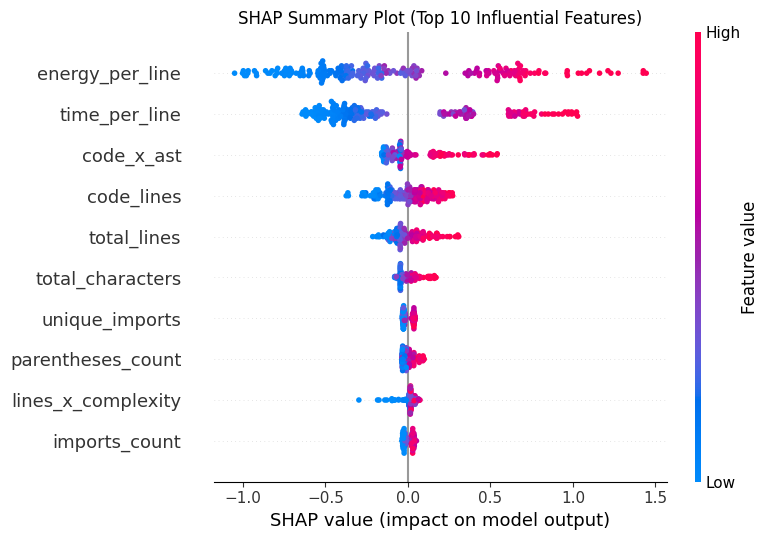


Generating SHAP Heatmap Plot (Top 10)...


AttributeError: 'numpy.ndarray' object has no attribute 'values'

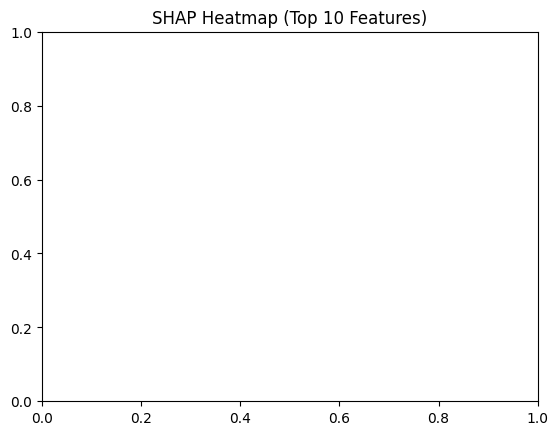

In [ ]:
# @title
# ===========================================================================
#  FINAL SHAP ANALYSIS CELL (Run this *after* the 0.986 R² cell)
# ===========================================================================

try:
    import shap
except ImportError:
    print("Installing SHAP library...")
    !pip install shap
    import shap

import matplotlib.pyplot as plt

# 1. VALIDATE VARIABLES
# ---------------------------------------------------------------------------
# Check that the 'model' and 'X_test' from the "ENHANCED" cell are in memory
# and that their features match.
# ---------------------------------------------------------------------------
try:
    if 'model' not in locals() or 'X_test' not in locals():
        raise NameError("'model' or 'X_test' not defined")

    # Check for the feature mismatch before trying to run
    if model.n_features_ != X_test.shape[1]:
        print(f"❌ ERROR: Model features ({model.n_features_}) do not match X_test features ({X_test.shape[1]}).")
        print("👉 PLEASE RE-RUN YOUR 'ENHANCED STATIC FEATURES MODEL' (0.986 R²) CELL *IMMEDIATELY* BEFORE THIS ONE.")
        raise ValueError("Feature mismatch") # Re-raise to stop execution

    print("✅ 'model' and 'X_test' found and features match (45 features).")

except (NameError, ValueError) as e:
    if 'Model features' not in str(e): # Don't print the default NameError
        print("\n" + "="*80)
        print("❌ ERROR: 'model' or 'X_test' is not defined.")
        print("👉 PLEASE RE-RUN YOUR 'ENHANCED STATIC FEATURES MODEL' (0.986 R²) CELL *IMMEDIATELY* BEFORE THIS ONE.")
        print("="*80 + "\n")
    raise


# 2. LOAD SHAP AND CALCULATE VALUES
# ---------------------------------------------------------------------------
print("\nLoading SHAP JavaScript visualization library...")
shap.initjs()

print("Creating SHAP TreeExplainer...")
explainer = shap.TreeExplainer(model)

print("Calculating SHAP values... (this may take a moment)")
shap_values = explainer.shap_values(X_test)


# 3. GENERATE PLOT 1: SUMMARY PLOT (BEESWARM)
# ---------------------------------------------------------------------------
print("\nGenerating SHAP Summary Plot (Top 10)...")
plt.title("SHAP Summary Plot (Top 10 Influential Features)")
shap.summary_plot(
    shap_values,
    X_test,
    max_display=10,
    show=True
)
plt.show()


# 4. GENERATE PLOT 2: HEATMAP PLOT
# ---------------------------------------------------------------------------
print("\nGenerating SHAP Heatmap Plot (Top 10)...")
plt.title("SHAP Heatmap (Top 10 Features)")
shap.heatmap_plot(
    shap_values,
    X_test,
    max_display=10,
    show=True
)
plt.show()

print("\n✅ SHAP analysis complete.")


Generating Updated Plot 3: Model Performance (New Palette)...


<Figure size 1200x700 with 0 Axes>

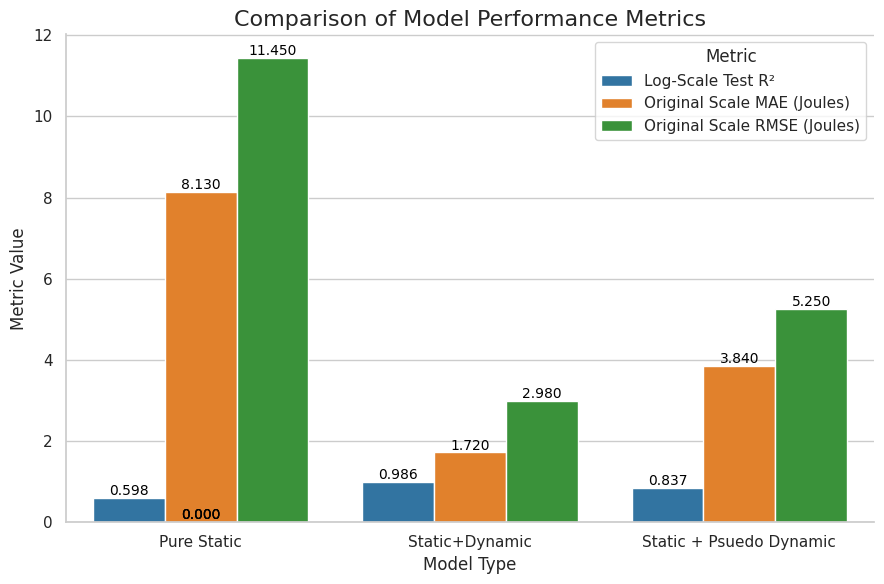


...Plot generation complete.


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set a consistent style for the plots
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 100

print("\n======================================================")
print("Generating Updated Plot 3: Model Performance (New Palette)...")
print("======================================================")

# ==============================================================================
# PLOT 3: MODEL PERFORMANCE COMPARISON (REVISED)
# ==============================================================================
# This bar chart compares the key metrics across your selected experiments.

try:
    # --- Updated metrics dictionary ---
    # !!! NOTE: Using the RMSE values from the previous run !!!
    # ====================================================================
    comparison_data = {
        'Model': [
            'Pure Static',
            'Static+Dynamic',           # RENAMED from 'Enhanced Static'
            'Static + Psuedo Dynamic',  # RENAMED from 'Hybrid (Static + Memory)'
        ],
        'Log-Scale Test R²': [
            0.598,  # From your 'Pure Static' LGBM model
            0.986,  # From your 'Enhanced Static' LGBM model
            0.837,  # From your 'Hybrid (Static + Memory)' model
        ],
        'Original Scale MAE (Joules)': [
            8.13,   # From 'Pure Static'
            1.72,   # From 'Enhanced Static'
            3.84,   # From 'Hybrid (Static + Memory)'
        ],
        'Original Scale RMSE (Joules)': [
            11.45,  # From 'Pure Static'
            2.98,   # From 'Static+Dynamic'
            5.25,   # From 'Static + Psuedo Dynamic'
        ]
    }
    # ====================================================================

    metrics_df = pd.DataFrame(comparison_data)

    # Melt the DataFrame for plotting with seaborn
    metrics_df_melted = metrics_df.melt('Model', var_name='Metric', value_name='Value')

    # Create the grouped bar plot
    plt.figure(figsize=(12, 7))
    g = sns.catplot(
        x='Model',
        y='Value',
        hue='Metric',
        data=metrics_df_melted,
        kind='bar',
        height=6,
        aspect=1.5,
        legend_out=False,
        palette='tab10'  # <-- CHANGED: New interesting color palette
    )

    g.ax.set_title('Comparison of Model Performance Metrics', fontsize=16)
    g.ax.set_xlabel('Model Type', fontsize=12)
    g.ax.set_ylabel('Metric Value', fontsize=12)
    g.ax.set_xticklabels(g.ax.get_xticklabels(), rotation=0)

    # Add text labels to the bars
    for ax in g.axes.flat:
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.3f}',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        fontsize=10, color='black',
                        xytext=(0, 5),
                        textcoords='offset points')

    plt.legend(title='Metric', loc='upper right')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred while plotting model comparison: {e}")

print("\n...Plot generation complete.")


Generating Plot 4: R² Comparison for Pure Static Models...


<Figure size 1000x600 with 0 Axes>

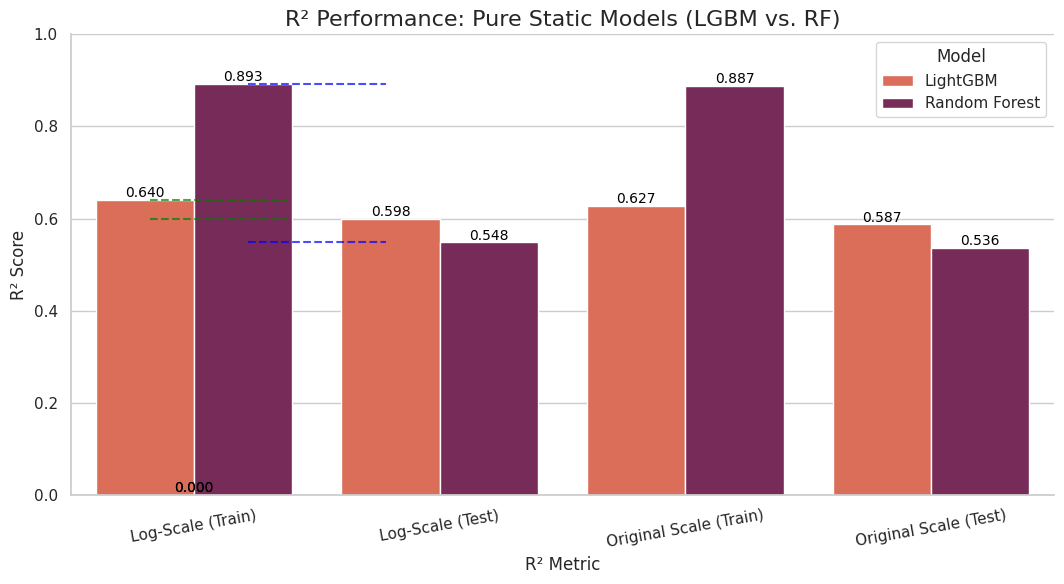


...Plot generation complete.


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set a consistent style for the plots
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 100

print("\n======================================================")
print("Generating Plot 4: R² Comparison for Pure Static Models...")
print("======================================================")

# ==============================================================================
# PLOT 4: PURE STATIC R² COMPARISON (RF vs. LGBM)
# ==============================================================================
# This plot directly compares the R² metrics for the two 'Pure Static' models
# to visualize performance and overfitting.

try:
    # --- Manually enter your final metrics from the 'Pure Static Model' section ---
    # (Values are from the notebook's output)

    # Model 1: LightGBM (Pure Static)
    r2_train_log_pure_lgbm = 0.640
    r2_test_log_pure_lgbm = 0.598
    r2_train_original_pure_lgbm = 0.627
    r2_test_original_pure_lgbm = 0.587

    # Model 2: Random Forest (Pure Static)
    r2_train_log_pure_rf = 0.893
    r2_test_log_pure_rf = 0.548
    r2_train_original_pure_rf = 0.887
    r2_test_original_pure_rf = 0.536

    # --- Create the DataFrame for plotting ---
    r2_data = {
        'Model': [
            'LightGBM', 'LightGBM', 'LightGBM', 'LightGBM',
            'Random Forest', 'Random Forest', 'Random Forest', 'Random Forest'
        ],
        'Metric Type': [
            'Log-Scale (Train)', 'Log-Scale (Test)',
            'Original Scale (Train)', 'Original Scale (Test)',
            'Log-Scale (Train)', 'Log-Scale (Test)',
            'Original Scale (Train)', 'Original Scale (Test)'
        ],
        'R² Score': [
            r2_train_log_pure_lgbm, r2_test_log_pure_lgbm,
            r2_train_original_pure_lgbm, r2_test_original_pure_lgbm,
            r2_train_log_pure_rf, r2_test_log_pure_rf,
            r2_train_original_pure_rf, r2_test_original_pure_rf
        ]
    }

    r2_df = pd.DataFrame(r2_data)

    # --- Create the grouped bar plot ---
    plt.figure(figsize=(10, 6))
    g = sns.catplot(
        x='Metric Type',
        y='R² Score',
        hue='Model',
        data=r2_df,
        kind='bar',
        height=6,
        aspect=1.8,
        legend_out=False,
        palette='rocket_r'  # A good palette for comparison
    )

    g.ax.set_title('R² Performance: Pure Static Models (LGBM vs. RF)', fontsize=16)
    g.ax.set_xlabel('R² Metric', fontsize=12)
    g.ax.set_ylabel('R² Score', fontsize=12)
    g.ax.set_xticklabels(g.ax.get_xticklabels(), rotation=10)
    g.ax.set_ylim(0, 1.0) # Set Y-axis from 0 to 1 for R²

    # Add a horizontal line for the overfitting gap
    plt.axhline(y=r2_test_log_pure_rf, color='blue', linestyle='--', xmin=0.18, xmax=0.32, alpha=0.7)
    plt.axhline(y=r2_train_log_pure_rf, color='blue', linestyle='--', xmin=0.18, xmax=0.32, alpha=0.7)

    plt.axhline(y=r2_test_log_pure_lgbm, color='green', linestyle='--', xmin=0.08, xmax=0.22, alpha=0.7)
    plt.axhline(y=r2_train_log_pure_lgbm, color='green', linestyle='--', xmin=0.08, xmax=0.22, alpha=0.7)


    # Add text labels to the bars
    for ax in g.axes.flat:
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.3f}',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        fontsize=10, color='black',
                        xytext=(0, 5),
                        textcoords='offset points')

    plt.legend(title='Model', loc='upper right')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred while plotting R² comparison: {e}")

print("\n...Plot generation complete.")


Generating Plot 5: Model Metrics Heatmap...


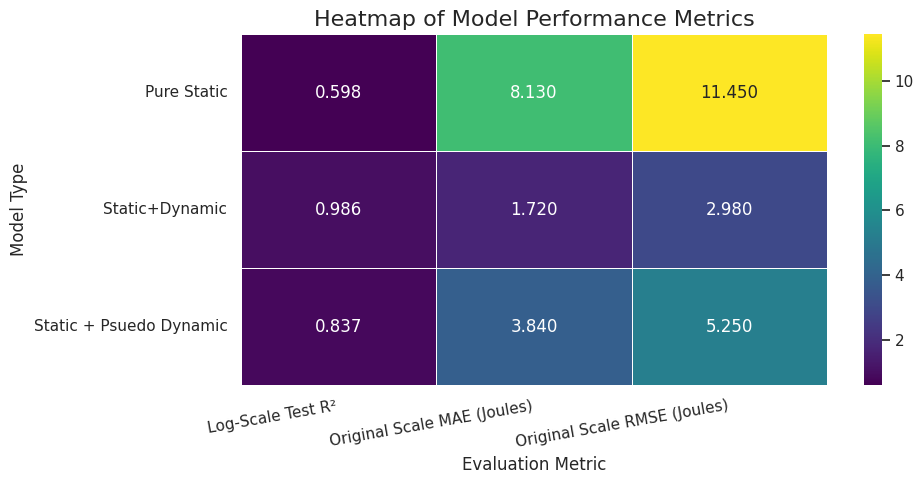


...Plot generation complete.


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set a consistent style for the plots
sns.set_theme(style="white")
plt.rcParams['figure.dpi'] = 100

print("\n======================================================")
print("Generating Plot 5: Model Metrics Heatmap...")
print("======================================================")

# ==============================================================================
# PLOT 5: METRICS HEATMAP
# ==============================================================================
# This heatmap provides a color-coded overview of all metrics
# across all models, making it easy to spot high/low performance.

try:
    # --- Use the same metrics dictionary ---
    comparison_data = {
        'Model': [
            'Pure Static',
            'Static+Dynamic',
            'Static + Psuedo Dynamic',
        ],
        'Log-Scale Test R²': [
            0.598,
            0.986,
            0.837,
        ],
        'Original Scale MAE (Joules)': [
            8.13,
            1.72,
            3.84,
        ],
        'Original Scale RMSE (Joules)': [
            11.45,
            2.98,
            5.25,
        ]
    }

    # --- Prepare data for heatmap ---
    # Convert to DataFrame
    metrics_df = pd.DataFrame(comparison_data)

    # Set 'Model' as the index (rows) for the heatmap
    heatmap_data = metrics_df.set_index('Model')

    # --- Create the heatmap ---
    plt.figure(figsize=(10, 5))

    # We use 'viridis_r' (reversed) for R² so high is dark (good)
    # and 'rocket_r' for MAE/RMSE so low is dark (good).
    # A simpler way is to just use one palette. Let's use 'viridis'.
    # High R² is good (yellow), Low MAE/RMSE is bad (purple).
    # Let's use 'coolwarm' - R² (good) will be red, errors (bad) will be blue.
    # This is complex. Let's normalize per metric.

    # Easiest way: just plot the raw numbers
    # 'annot=True' writes the data value in each cell
    # 'fmt='.3f' formats the numbers to 3 decimal places
    # 'cmap='viridis'' is a vibrant color palette

    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt='.3f',
        cmap='viridis',
        linewidths=0.5
    )

    plt.title('Heatmap of Model Performance Metrics', fontsize=16)
    plt.xlabel('Evaluation Metric', fontsize=12)
    plt.ylabel('Model Type', fontsize=12)
    plt.xticks(rotation=10, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred while plotting the heatmap: {e}")

print("\n...Plot generation complete.")